# Import

In [176]:
import pandas as pd  # analyze table/data
import numpy as np  # calculation
import seaborn as sns  #visualization
import matplotlib.pyplot as plt # visual
import time
import datetime
import math
import os.path
import webbrowser
import shap
import pickle
from IPython.display import display, Markdown, HTML
from tqdm import tqdm
from scipy.stats import norm
from collections import Counter
import statsmodels.api as sm
import dataframe_image as dfi
import warnings
warnings.filterwarnings("ignore")

# data split
from sklearn.model_selection import train_test_split, StratifiedKFold

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import scikitplot as skplt
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# model evaluation
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn import metrics


# package
import sys
sys.path.append(r'D:\Superprof\Package')

from MOBPY.MOB import MOB
from MOBPY.plot.MOB_PLOT import MOB_PLOT
from MOBPY.stepwiseSelection import forwardSelection, backwardSelection

In [2]:
pwd

'D:\\Superprof\\Materials'

In [3]:
# create documentation folder
currentPath = os.path.abspath('D:/Superprof/Materials/Documentation/documentation_module_logreg/')
output_folder = os.path.join(currentPath, "documentation_model")
subfolders = [
    "predictors",      # for storing woe binning
    "analysis",        # for storing bad rate, correlation matrix, etc
    "model"   ,        # for storing model documentation (scorecard, MC, etc)
    "performance",     # for storing model performance (ROC, lift, etc)
    "stability"        # gini stability , etc
]

os.makedirs(output_folder, exist_ok=True)

for folder in subfolders:
    os.makedirs(os.path.join(output_folder, folder), exist_ok=True)

In [4]:
df = pd.read_csv('D:/Superprof/Materials/Bank_Loan_Data/Bank Data.csv')
df.columns = df.columns.str.lower()

In [5]:
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


# Machine Learning - Classification (Train-Valid-Test Method)

Reference for reading: https://medium.com/@masadeghi6/how-to-split-your-data-for-machine-learning-eae893a8799c

## Data Preparation

### Define Column

In [7]:
# Define column
col_id = 'customer_id'
col_base = 'base'
# col_month = 'month'
# col_time=''
col_target = 'churn'
col_pred = [col for col in df.columns if col not in [col_id, col_target]]
col_id_w_pred = [col for col in df.columns if col not in [col_target]]

In [8]:
col_id_w_pred

['customer_id',
 'credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [9]:
col_pred

['credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [10]:
# define categorical and numerical columns
col_pred_cat = df[col_pred].select_dtypes(include=['object']).columns.tolist()
col_pred_num = df[col_pred].select_dtypes(include=['number']).columns.tolist()

In [11]:
col_pred_cat

['country', 'gender']

In [12]:
col_pred_num

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

### Data Splitting

In [13]:
def partition_custom(X, y, test_frac:float):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=(test_frac/(1-test_frac)), stratify=y_train, random_state=42)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [14]:
# Split train - valid - test to 40-30-30
X_train, X_valid, X_test, y_train, y_valid, y_test = partition_custom(df[col_id_w_pred], df[col_target], 0.30)

In [15]:
# Reconstruct dataframes with index preserved
X_train_ = X_train.copy()
X_train_[col_target] = y_train
X_train_['datatype'] = 'Train'

X_valid_ = X_valid.copy()
X_valid_[col_target] = y_valid
X_valid_['datatype'] = 'Valid'

X_test_ = X_test.copy()
X_test_[col_target] = y_test
X_test_['datatype'] = 'Test'

# Combine all into one DataFrame
data = pd.concat([X_train_, X_valid_, X_test_], axis=0).reset_index(drop=True)
data['base'] = 1

In [16]:
data

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,datatype,base
0,15604832,633,France,Male,29,7,0.00,1,1,1,130224.73,0,Train,1
1,15793693,694,France,Male,60,9,0.00,1,1,1,57088.97,0,Train,1
2,15804150,755,France,Male,34,3,0.00,2,1,1,158816.03,0,Train,1
3,15801994,775,France,Male,31,9,0.00,2,1,0,169278.51,0,Train,1
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,44384.57,1,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15772216,738,France,Female,67,1,130652.52,1,0,1,22762.23,0,Test,1
9996,15680895,627,Spain,Female,35,7,0.00,1,1,0,187718.26,0,Test,1
9997,15765650,501,Germany,Male,40,5,114655.58,1,0,0,126535.92,0,Test,1
9998,15663446,792,Germany,Female,29,4,107601.79,1,1,0,18922.18,1,Test,1


### Masking Data

In [17]:
train_mask = (data['base'] == 1) & (data['datatype'] == 'Train')
valid_mask = (data['base'] == 1) & (data['datatype'] == 'Valid')
test_mask = (data['base'] == 1) & (data['datatype'] == 'Test')

In [18]:
data[train_mask]

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,datatype,base
0,15604832,633,France,Male,29,7,0.00,1,1,1,130224.73,0,Train,1
1,15793693,694,France,Male,60,9,0.00,1,1,1,57088.97,0,Train,1
2,15804150,755,France,Male,34,3,0.00,2,1,1,158816.03,0,Train,1
3,15801994,775,France,Male,31,9,0.00,2,1,0,169278.51,0,Train,1
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,44384.57,1,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,15652693,573,France,Female,26,4,129109.02,1,0,0,149814.68,1,Train,1
3996,15629475,656,France,Male,41,2,0.00,2,1,0,158973.77,0,Train,1
3997,15670914,754,France,Male,38,2,0.00,2,1,0,180698.32,0,Train,1
3998,15709338,544,France,Female,29,1,118560.55,1,1,1,164137.36,0,Train,1


### Check Bad Rate

In [19]:
# Total Rows
shape_train = data[train_mask].shape[0]
shape_valid = data[valid_mask].shape[0]
shape_test = data[test_mask].shape[0]

# Target Rate total
target_cnt_train = data[train_mask][col_target].sum()
target_cnt_valid = data[valid_mask][col_target].sum()
target_cnt_test = data[test_mask][col_target].sum()

# Target Rate of each Datatype
target_rate_train = data[train_mask][col_target].mean()
target_rate_valid = data[valid_mask][col_target].mean()
target_rate_test = data[test_mask][col_target].mean()

In [20]:
df_summary = pd.DataFrame({
    'Datatype': ['Train', 'Valid', 'Test'],
    'Total': [shape_train, shape_valid, shape_test],
    'Total Bad (Churn)': [target_cnt_train, target_cnt_valid, target_cnt_test],
    'Bad Rate': [target_rate_train, target_rate_valid, target_rate_test]
})

df_summary

,Datatype,Total,Total Bad (Churn),Bad Rate
0,Train,4000,815,0.203750
1,Valid,3000,611,0.203667
2,Test,3000,611,0.203667


In [21]:
save_folder = os.path.join(output_folder, "analysis")

# define table styling
table_styles = """
<style>
    table {
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
    }
    th, td {
        border: 1px solid #dddddd;
        text-align: center;
        padding: 8px;
    }
    th {
        background-color: #004c99;
        color: white;
    }
    tr:nth-child(even) {
        background-color: #f2f2f2;
    }
</style>
"""

# Convert DataFrame to HTML table
html_table = df_summary.to_html(index=False, border=0)

# Combine CSS and table
html_content = f"{table_styles}\n{html_table}"

# Save to HTML file
html_file = os.path.join(save_folder, "bad_rate.html")
with open(html_file, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"Styled HTML table saved to: {html_file}")

Styled HTML table saved to: D:\Superprof\Materials\Documentation\documentation_module_logreg\documentation_model\analysis\bad_rate.html


In [22]:
format_dict = {
    'float': '{:.3f}', 
}

def custom_format(x, format_dict):
    if pd.isnull(x):
        return ''
    elif isinstance(x, float):
        return format_dict.get('float', '{:.3f}').format(x)
    else:
        return x

cmap = 'RdYlGn'
subset = pd.IndexSlice[:, df_summary.iloc[:, 2:3].columns]

df_styled = (
    df_summary.style
    .format(lambda x: custom_format(x, format_dict))
    .set_table_styles([
        {'selector': 'th',
         'props': [
             ('background-color', '#004c99'),
             ('color', 'white')]}
    ])
    .set_properties(**{'text-align': 'center'})
    .background_gradient(cmap=cmap, subset=['Total Bad (Churn)'])
)


In [23]:
df_styled

,Datatype,Total,Total Bad (Churn),Bad Rate
0,Train,4000,815,0.204
1,Valid,3000,611,0.204
2,Test,3000,611,0.204


In [24]:
save_folder

'D:\\Superprof\\Materials\\Documentation\\documentation_module_logreg\\documentation_model\\analysis'

In [25]:
# # save to excel
# df_styled.to_excel(save_folder + "/bad_rate_summary.xlsx", engine='openpyxl')

In [26]:
# save to png
png_file = os.path.join(save_folder, "bad_rate.png")
dfi.export(df_styled, png_file, table_conversion='matplotlib')

## Grouping and WoE Transformation

Weight of Evidence (WOE) and Information Value (IV) are often used as pre-processing techniques in logistic regression, specifically in the context of binary classification problems where the dependent variable is categorical with two outcomes (0 or 1).

WOE is applied to transform predictor variables, especially categorical or continuous ones, into a format suitable for logistic regression. WOE helps in treating missing values logically for both types of variables — categorical and continuous. The original variable values in the dataset can be replaced with Calculated WoE value and the dataset with WOE-transformed variables can be used for logistic regression modelling.

**How to Calculate WOE?**
- Step 1: Data Binning/Grouping

For continuous variables, divide the variable into bins or intervals. For categorical variables, each category is treated as a separate bin.

- Step 2: Calculate WOE

For each bin, calculate the percentage of events and non-events.

Calculate the Weight of Evidence (WOE) using the formula:

WOE=ln(%of Events / %of Non-events​)


**What is Information Value (IV)?**

Information Value (IV) is a metric used to measure the predictive power of a variable in a binary classification model, such as logistic regression. The IV is often calculated in conjunction with the Weight of Evidence (WOE) for each category or bin of a predictor variable.

**How to Calculate IV?**

IV=∑(%of Non-events−%of Events)×WOE

- I. Calculate the WOE for each bin or category of a variable.

- II. Calculate the percentage of events and non-events in each bin.

- III. Compute the difference between the percentage of non-events and events in each bin.

- IV. Multiply the difference by the WOE for each bin.

- V. Sum up the results across all bins to get the Information Value.


**Needs of WOE & IV**

· Variable Transformation: WOE helps in transforming continuous variables into a form that is more suitable for modelling, especially for logistic regression.

· Handling non-linearity: Logistic regression assumes a linear relationship between the independent variables and the log-odds of the dependent variable. WOE allows for capturing non-linear relationships and improves the model’s ability to handle complex patterns.

· Addresses Outliers: WOE is less sensitive to outliers compared to other encoding methods. It places more emphasis on the distribution of events and non-events rather than specific data points.

· Feature Selection: IV provides a measure of the predictive power of each variable. High IV values indicate strong predictive power, and variables with low or zero IV may be considered for removal from the model, reducing complexity and potential overfitting.

· Ranking Variables: IV allows ranking of variables based on their importance in predicting the target variable.

· Handling Missing Values: WOE can handle missing values by creating a separate category for them during the binning process, ensuring that information from missing values is not lost.

· Model Performance Enhancement: WOE-driven feature selection improves model accuracy, stability, and interpretability.

### WoE Method

#### Method 1

Cons: Simple, does not consider monotonicity

In [27]:
# [[MEDIUM]]
def calculate_woe_iv(dataset, feature_b, target):

    dataset[feature_b].replace([np.inf, -np.inf], np.nan, inplace = True)

    if dataset[feature_b].dtype in ['float64', 'int64'] and 'flag' not in feature_b.lower():
        dataset['feature'] = pd.qcut(dataset[feature_b], q = [0, .05, .1, .2,.4, .6, .8,0.9,0.95, 1],
                                     duplicates = 'drop', precision = 0).values.add_categories(['Missing', 'NaN'])
    else:
        dataset['feature'] = dataset[feature_b]

    dataset['feature'].fillna('NaN', inplace = True)

    lst = []
    num_rows = dataset.shape[0]

    val_list = dataset['feature'].unique()
    for val in val_list:
        occ_val = dataset[dataset['feature'] == val].count()['feature']
        if occ_val < 0.1 * num_rows :
            dataset['feature'] = np.where(dataset['feature'] == val, 'NaN', dataset['feature'])

    val_list = dataset['feature'].unique()
    for val in val_list:
        lst.append({
        'Feature': feature_b,
        'Value': val,
        'All': dataset[dataset['feature'] == val].count()['feature'],
        'Good': dataset[(dataset['feature'] == val) & (dataset[target] == 0)].count()['feature'],
        'Bad': dataset[(dataset['feature'] == val) & (dataset[target] == 1)].count()['feature']
        })

    dset = pd.DataFrame(lst)
    dset['Event_rate'] = dset['Bad'] / dset['All']
    dset['Prop'] = dset['All'] / dset['All'].sum()
    dset['Prop_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Prop_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['woe'] = np.log(dset['Prop_Good'] / dset['Prop_Bad'])
    dset = dset.replace({'woe': {np.inf: 0, -np.inf: 0}})
    dset['iv_grp'] = (dset['Prop_Good'] - dset['Prop_Bad']) * dset['woe']

    iv = dset['iv_grp'].sum()

    dset = dset.sort_values(by = 'Event_rate')

    return  dset, iv

In [62]:
# from scipy.stats import spearmanr

# def calculate_woe_iv_tree(dataset, feature_b, target, max_leaf_nodes=10, min_samples_leaf=0.05):
#     df = dataset[[feature_b, target]].copy()
#     df[feature_b].replace([np.inf, -np.inf], np.nan, inplace=True)

#     missing_mask = df[feature_b].isna()
#     df[feature_b].fillna(-999999, inplace=True)

#     if df[feature_b].dtype in ['float64', 'int64'] and 'flag' not in feature_b.lower():
#         tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, random_state=42)
#         tree.fit(df[[feature_b]], df[target])

#         thresholds = tree.tree_.threshold
#         thresholds = thresholds[thresholds != -2]
#         thresholds = np.sort(thresholds)
#         bins = [-np.inf] + thresholds.tolist() + [np.inf]
#         df['feature'] = pd.cut(df[feature_b], bins=bins).astype(str)
#     else:
#         df['feature'] = df[feature_b].astype(str)

#     df.loc[missing_mask, 'feature'] = 'NaN'

#     num_rows = df.shape[0]
#     val_counts = df['feature'].value_counts()
#     rare_values = val_counts[val_counts < 0.05 * num_rows].index
#     df['feature'] = df['feature'].replace(rare_values, 'Others')

#     # Compute WOE/IV
#     def compute_woe_iv(df_in, target_col):
#         lst = []
#         for val in df_in['feature'].unique():
#             sub = df_in[df_in['feature'] == val]
#             all_ = len(sub)
#             good = len(sub[sub[target_col] == 0])
#             bad = len(sub[sub[target_col] == 1])
#             lst.append({
#                 'Value': val,
#                 'All': all_,
#                 'Good': good,
#                 'Bad': bad
#             })
#         dset = pd.DataFrame(lst)
#         dset['Event_rate'] = dset['Bad'] / dset['All']
#         dset['Prop'] = dset['All'] / dset['All'].sum()
#         dset['Prop_Good'] = dset['Good'] / dset['Good'].sum()
#         dset['Prop_Bad'] = dset['Bad'] / dset['Bad'].sum()
#         dset['WoE'] = np.log(dset['Prop_Good'] / dset['Prop_Bad']).replace([np.inf, -np.inf], 0)
#         dset['IV_component'] = (dset['Prop_Good'] - dset['Prop_Bad']) * dset['WoE']
#         return dset

#     dset = compute_woe_iv(df, target)
#     dset = dset.sort_values(by='Value')

#     # Check monotonicity
#     try:
#         # Convert Value to numeric midpoint if binned
#         if df[feature_b].dtype in ['float64', 'int64']:
#             bin_mid = dset['Value'].apply(lambda x: (pd.Interval(left=float(x.split(',')[0].replace('(', '').replace('[', '')),
#                                                                  right=float(x.split(',')[1].replace(']', '').replace(')', ''))) if ',' in x else 0).mid)
#             corr, _ = spearmanr(bin_mid, dset['WoE'])
#         else:
#             corr, _ = spearmanr(range(len(dset)), dset['WoE'])

#         # If not monotonic, print warning (could implement bin merging if needed)
#         if abs(corr) < 0.9:
#             print(f"Warning: WoE for '{feature_b}' is not monotonic (Spearman r = {corr:.2f})")

#     except Exception as e:
#         print(f"Could not assess monotonicity for '{feature_b}': {e}")

#     iv = dset['IV_component'].sum()
#     dset.insert(0, 'Feature', feature_b)

#     return dset, iv


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Predictor: credit_score
IV: 0.0364


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
9,credit_score,"(-inf, 518.5]",383,298,85,0.221932,0.09575,0.093564,0.104294,-0.108577,0.001165
5,credit_score,"(518.5, 560.5]",375,276,99,0.264000,0.09375,0.086656,0.121472,-0.337738,0.011759
6,credit_score,"(560.5, 624.5]",808,646,162,0.200495,0.20200,0.202826,0.198773,0.020184,0.000082
0,credit_score,"(624.5, 651.5]",440,343,97,0.220455,0.11000,0.107692,0.119018,-0.100000,0.001133
4,credit_score,"(651.5, 680.5]",428,349,79,0.184579,0.10700,0.109576,0.096933,0.122605,0.001550
8,credit_score,"(680.5, 693.5]",200,154,46,0.230000,0.05000,0.048352,0.056442,-0.154708,0.001252
1,credit_score,"(693.5, 735.5]",559,464,95,0.169946,0.13975,0.145683,0.116564,0.222988,0.006493
2,credit_score,"(735.5, 768.5]",318,246,72,0.226415,0.07950,0.077237,0.088344,-0.134354,0.001492
3,credit_score,"(768.5, 801.5]",224,193,31,0.138393,0.05600,0.060597,0.038037,0.465684,0.010506
7,credit_score,"(801.5, inf]",265,216,49,0.184906,0.06625,0.067818,0.060123,0.120439,0.000927


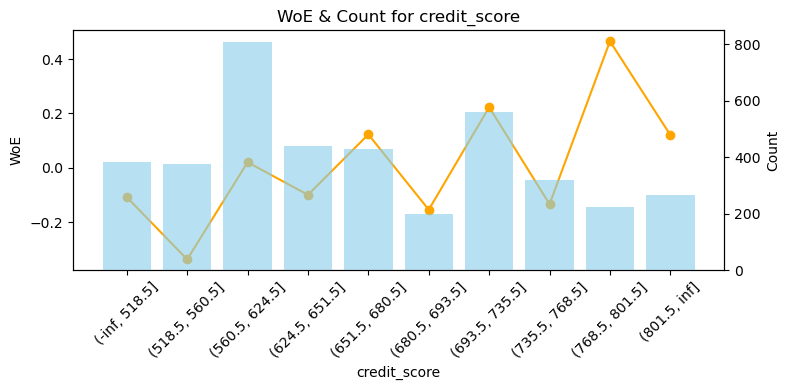

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.27it/s]

Predictor: country
IV: 0.1704


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
0,country,France,2030,1712,318,0.156650,0.50750,0.537520,0.390184,0.320347,0.047198
1,country,Germany,1007,681,326,0.323734,0.25175,0.213815,0.400000,-0.626355,0.116618
2,country,Spain,963,792,171,0.177570,0.24075,0.248666,0.209816,0.169878,0.006600


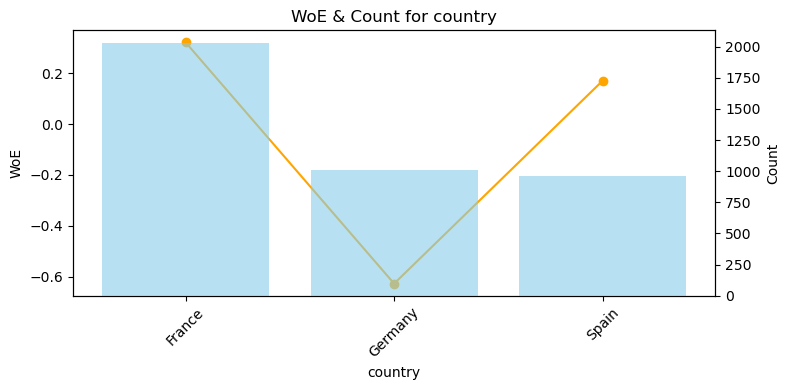

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  4.40it/s]

Predictor: gender
IV: 0.0678


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
1,gender,Female,1800,1349,451,0.250556,0.45,0.423548,0.553374,-0.267368,0.034711
0,gender,Male,2200,1836,364,0.165455,0.55,0.576452,0.446626,0.255171,0.033128


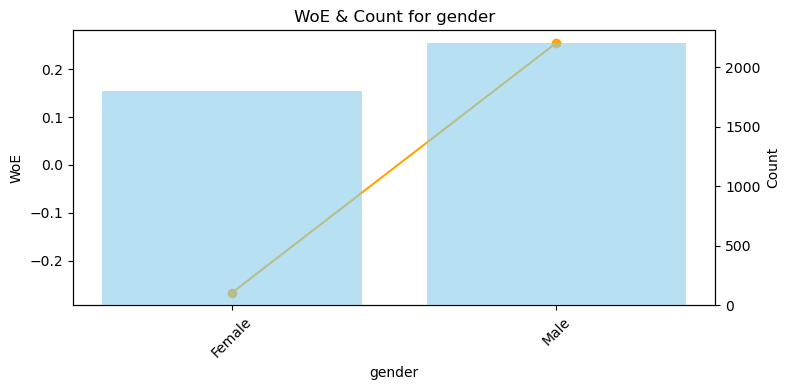

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  5.35it/s]

Predictor: age
IV: 0.7552


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
7,age,"(-inf, 25.5]",225,211,14,0.062222,0.05625,0.066248,0.017178,1.349781,6.623394e-02
0,age,"(25.5, 30.5]",553,499,54,0.097649,0.13825,0.156672,0.066258,0.860603,7.781072e-02
2,age,"(30.5, 34.5]",691,631,60,0.086831,0.17275,0.198116,0.073620,0.989942,1.232443e-01
4,age,"(34.5, 36.5]",352,312,40,0.113636,0.08800,0.097959,0.049080,0.691104,3.378078e-02
9,age,"(36.5, 39.5]",568,483,85,0.149648,0.14200,0.151648,0.104294,0.374346,1.772673e-02
3,age,"(39.5, 42.5]",491,391,100,0.203666,0.12275,0.122763,0.122699,0.000518,3.292145e-08
5,age,"(42.5, 46.5]",399,263,136,0.340852,0.09975,0.082575,0.166871,-0.703520,5.930437e-02
6,age,"(46.5, 50.5]",246,128,118,0.479675,0.06150,0.040188,0.144785,-1.281674,1.340591e-01
8,age,"(50.5, 59.5]",270,120,150,0.555556,0.06750,0.037677,0.184049,-1.586163,2.321706e-01
1,age,"(59.5, inf]",205,147,58,0.282927,0.05125,0.046154,0.071166,-0.433030,1.083086e-02


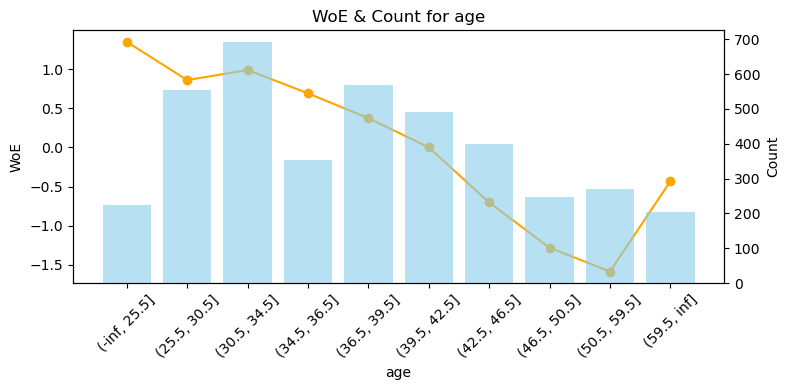

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  5.43it/s]

Predictor: tenure
IV: 0.0095


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
5,tenure,"(-inf, 1.5]",534,421,113,0.211610,0.13350,0.132182,0.138650,-0.047774,0.000309
8,tenure,"(1.5, 2.5]",428,352,76,0.177570,0.10700,0.110518,0.093252,0.169878,0.002933
2,tenure,"(2.5, 3.5]",421,332,89,0.211401,0.10525,0.104239,0.109202,-0.046521,0.000231
3,tenure,"(3.5, 4.5]",395,319,76,0.192405,0.09875,0.100157,0.093252,0.071438,0.000493
4,tenure,"(4.5, 5.5]",389,310,79,0.203085,0.09725,0.097331,0.096933,0.004105,0.000002
6,tenure,"(5.5, 6.5]",361,291,70,0.193906,0.09025,0.091366,0.085890,0.061809,0.000338
0,tenure,"(6.5, 7.5]",432,342,90,0.208333,0.10800,0.107378,0.110429,-0.028018,0.000085
9,tenure,"(7.5, 8.5]",429,348,81,0.188811,0.10725,0.109262,0.099387,0.094734,0.000936
1,tenure,"(8.5, 9.5]",406,311,95,0.233990,0.10150,0.097645,0.116564,-0.177103,0.003351
7,tenure,"(9.5, inf]",205,159,46,0.224390,0.05125,0.049922,0.056442,-0.122757,0.000800


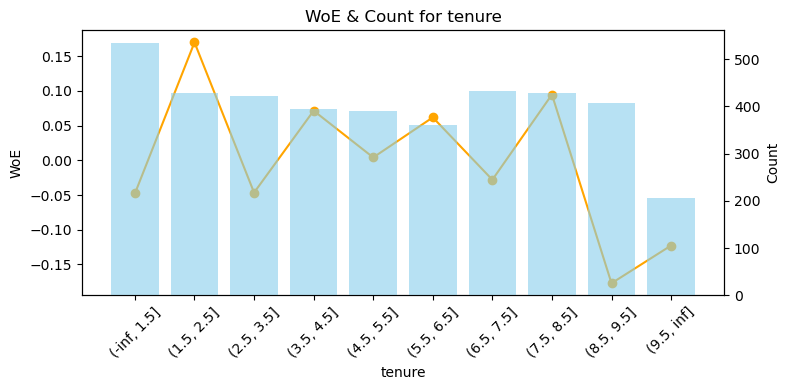

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  5.53it/s]

Predictor: balance
IV: 0.1456


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
0,balance,"(-inf, 20468.52]",1451,1248,203,0.139904,0.36275,0.391837,0.249080,0.453072,0.064679
1,balance,"(107057.285, 115721.16]",301,217,84,0.279070,0.07525,0.068132,0.103067,-0.413939,0.014461
2,balance,"(115721.16, 123811.391]",263,172,91,0.346008,0.06575,0.054003,0.111656,-0.726384,0.041878
6,balance,"(123811.391, 132682.633]",322,240,82,0.254658,0.08050,0.075353,0.100613,-0.289100,0.007303
8,balance,"(132682.633, 139552.133]",208,167,41,0.197115,0.05200,0.052433,0.050307,0.041402,0.000088
5,balance,"(139552.133, 148708.141]",220,159,61,0.277273,0.05500,0.049922,0.074847,-0.404989,0.010094
4,balance,"(148708.141, 162679.992]",201,163,38,0.189055,0.05025,0.051177,0.046626,0.093145,0.000424
9,balance,"(162679.992, inf]",204,154,50,0.245098,0.05100,0.048352,0.061350,-0.238090,0.003095
3,balance,"(20468.52, 99119.609]",602,490,112,0.186047,0.15050,0.153846,0.137423,0.112887,0.001854
7,balance,"(99119.609, 107057.285]",228,175,53,0.232456,0.05700,0.054945,0.065031,-0.168525,0.001700


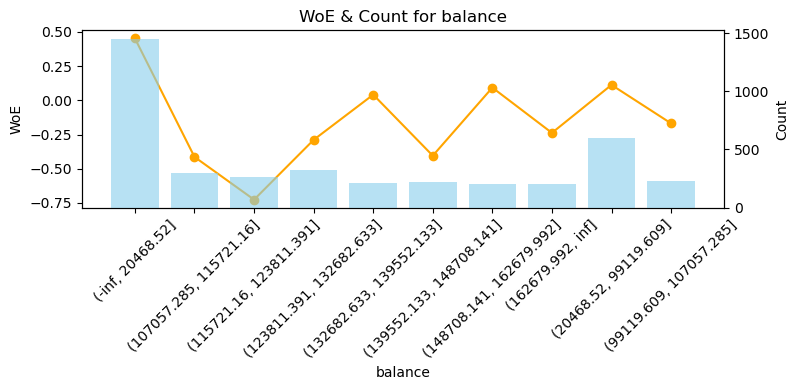

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:00,  5.52it/s]

Predictor: products_number
IV: 0.2083


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
0,products_number,"(-inf, 1.5]",2016,1460,556,0.275794,0.504,0.458399,0.682209,-0.397596,0.088986
1,products_number,"(1.5, inf]",1984,1725,259,0.130544,0.496,0.541601,0.317791,0.533135,0.119321


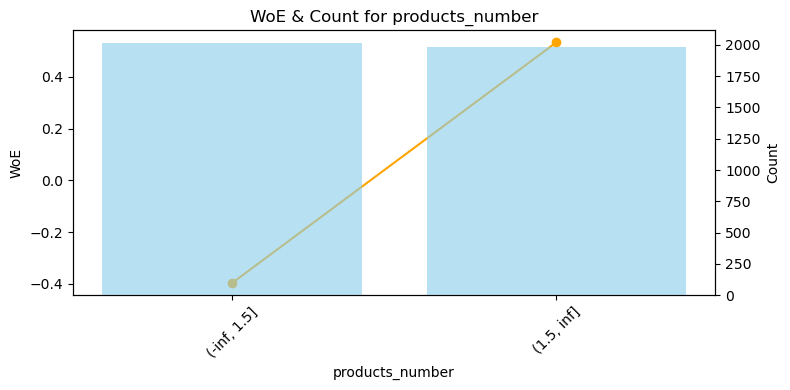

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.77it/s]

Predictor: credit_card
IV: 0.0005


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
1,credit_card,"(-inf, 0.5]",1181,934,247,0.209145,0.29525,0.29325,0.303067,-0.032931,0.000323
0,credit_card,"(0.5, inf]",2819,2251,568,0.201490,0.70475,0.70675,0.696933,0.013989,0.000137


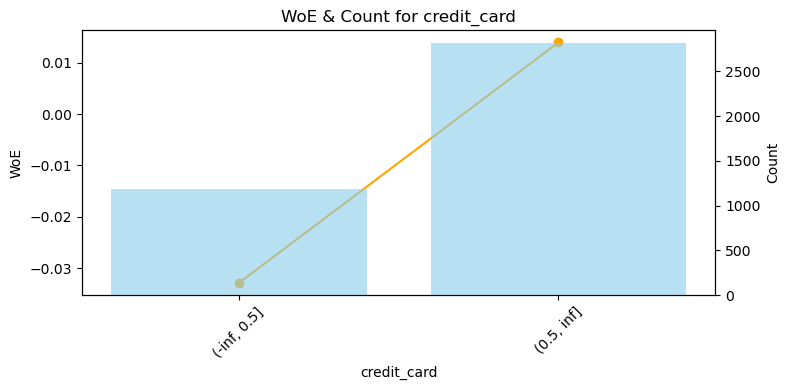

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  6.18it/s]

Predictor: active_member
IV: 0.1217


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
1,active_member,"(-inf, 0.5]",1932,1426,506,0.261905,0.483,0.447724,0.620859,-0.326928,0.056603
0,active_member,"(0.5, inf]",2068,1759,309,0.149420,0.517,0.552276,0.379141,0.376140,0.065123


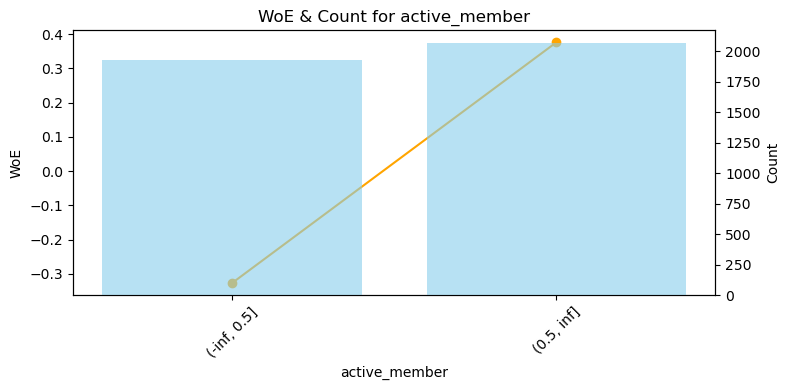

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  6.33it/s]

Predictor: estimated_salary
IV: 0.0418


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,WoE,IV_component
9,estimated_salary,"(-inf, 12433.385]",250,206,44,0.176000,0.06250,0.064678,0.053988,0.180667,0.001931
8,estimated_salary,"(105726.496, 123192.215]",341,257,84,0.246334,0.08525,0.080691,0.103067,-0.244760,0.005477
0,estimated_salary,"(123192.215, 138544.836]",292,238,54,0.184932,0.07300,0.074725,0.066258,0.120267,0.001018
5,estimated_salary,"(12433.385, 32736.95]",396,306,90,0.227273,0.09900,0.096075,0.110429,-0.139244,0.001999
7,estimated_salary,"(138544.836, 150836.094]",261,196,65,0.249042,0.06525,0.061538,0.079755,-0.259292,0.004723
2,estimated_salary,"(150836.094, 161421.25]",205,169,36,0.175610,0.05125,0.053061,0.044172,0.183360,0.001630
3,estimated_salary,"(161421.25, inf]",761,590,171,0.224704,0.19025,0.185243,0.209816,-0.124560,0.003061
4,estimated_salary,"(32736.95, 49892.295]",339,292,47,0.138643,0.08475,0.091680,0.057669,0.463587,0.015767
1,estimated_salary,"(49892.295, 92349.453]",893,710,183,0.204927,0.22325,0.222920,0.224540,-0.007241,0.000012
6,estimated_salary,"(92349.453, 105726.496]",262,221,41,0.156489,0.06550,0.069388,0.050307,0.321571,0.006136


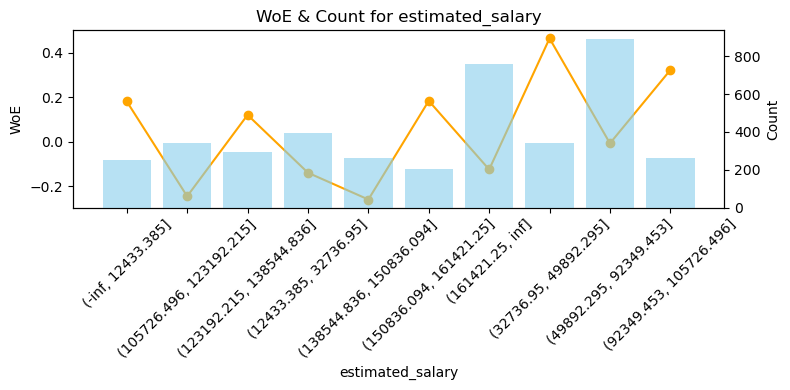

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.70it/s]


In [28]:
# woe_maps = {}

# for pred in tqdm(col_pred):
#     woe_df, iv = calculate_woe_iv_tree(data[train_mask], pred, col_target)
#     print(f"Predictor: {pred}")
#     print(f"IV: {iv:.4f}")
#     display(woe_df)

#     # Plot WoE & Counts
#     fig, ax = plt.subplots(figsize=(8, 4))
#     woe_df['Value'] = woe_df['Value'].astype(str)

#     ax.plot(woe_df['Value'], woe_df['WoE'], color='orange', marker='o', label='WoE')
#     ax.set_xlabel(pred)
#     ax.set_ylabel('WoE')
#     ax.tick_params(axis='x', rotation=45)

#     ax2 = ax.twinx()
#     ax2.bar(woe_df['Value'], woe_df['All'], color='skyblue', alpha=0.6, label='Count')
#     ax2.set_ylabel('Count')

#     plt.title(f'WoE & Count for {pred}')
#     plt.tight_layout()
#     plt.show()

#     # WoE mapping
#     woe_map = dict(zip(woe_df['Value'].astype(str), woe_df['WoE']))
#     woe_maps[pred] = woe_map

#     col_woe = f'{pred}_woe'
#     data[train_mask][col_woe] = data[train_mask][pred].astype(str).map(woe_map)


In [29]:
data[train_mask]

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,datatype,base
0,15604832,633,France,Male,29,7,0.00,1,1,1,130224.73,0,Train,1
1,15793693,694,France,Male,60,9,0.00,1,1,1,57088.97,0,Train,1
2,15804150,755,France,Male,34,3,0.00,2,1,1,158816.03,0,Train,1
3,15801994,775,France,Male,31,9,0.00,2,1,0,169278.51,0,Train,1
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,44384.57,1,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,15652693,573,France,Female,26,4,129109.02,1,0,0,149814.68,1,Train,1
3996,15629475,656,France,Male,41,2,0.00,2,1,0,158973.77,0,Train,1
3997,15670914,754,France,Male,38,2,0.00,2,1,0,180698.32,0,Train,1
3998,15709338,544,France,Female,29,1,118560.55,1,1,1,164137.36,0,Train,1


#### Method 2

Better, but only works on numerical columns. Output in tuple

In [28]:
class BinningProcessor:
    def __init__(self, df):
        self.df = df

    def binning(self, feature_col, label_col, p_value_threshold, min_bin_size, min_event_rate, sort_order):
        # Sort DataFrame based on the feature column
        sorted_df = self.df[[feature_col, label_col]].sort_values(by=[feature_col], ascending=sort_order)
        
        # Extract feature and label values as lists
        features = sorted_df[feature_col].tolist()
        labels = sorted_df[label_col].tolist()
        
        # Initialize stack to store bins
        stack = []

        # Iterate through each data point
        for i in range(len(features)):
            # Initialize a bin
            current_bin = [i, i, 0, labels[i]]
            
            # Determine whether to add the current bin to the stack
            if len(stack) == 0 or stack[-1][-1] > labels[i]:
                stack.append(current_bin)
            else:
                # Combine bins if necessary
                previous_bin = stack.pop()
                stack.append(self.combine_bins(previous_bin, current_bin))
                
                # Merge adjacent bins if needed
                j = len(stack) - 2
                while True:
                    if len(stack) == 1 or j == len(stack) - 1:
                        break
                    elif stack[j][-1] > stack[j + 1][-1]:
                        j += 1
                    elif stack[j][-1] <= stack[j + 1][-1]:
                        temp_1 = stack.pop()
                        temp_2 = stack.pop()
                        stack.append(self.combine_bins(temp_1, temp_2))
                        j -= 1

        # Iteratively merge bins based on p-value until threshold is met
        while True:
            p_value_table = []
            for i in range(1, len(stack)):
                p_value = self.calculate_p_value(stack[i - 1], stack[i], labels)
                if (stack[i - 1][1] - stack[i - 1][0] + 1 < min_bin_size) or (
                        sum(labels[stack[i - 1][0]:stack[i - 1][1] + 1]) < min_event_rate) or (
                        stack[i][1] - stack[i][0] + 1 < min_bin_size) or (
                        sum(labels[stack[i][0]:stack[i][1] + 1]) < min_event_rate):
                    p_value = p_value + 1
                p_value_table.append([p_value, stack[i]])
            if len(p_value_table) > 0:
                max_val = (p_value_table[0][0], 0)
                for j in range(1, len(p_value_table)):
                    if p_value_table[j][0] > max_val[0]:
                        max_val = (p_value_table[j][0], j)
                if max_val[0] > p_value_threshold:
                    bin_1 = stack.pop(max_val[1])
                    bin_2 = stack.pop(max_val[1])
                    stack.insert(max_val[1], self.combine_bins(bin_1, bin_2))
                else:
                    break
            else:
                break

        # Generate bins for final output
        bins = [features[i[1]] for i in stack]
        
        # Handle sorting order
        if sort_order:
            bins = [features[i[1]] for i in stack]
            bins.insert(0, -np.inf)
            bins[-1] = np.inf
        else:
            bins = [features[i[0]] for i in stack]
            bins[0] = -np.inf
            bins.insert(-1, np.inf)
            bins.sort()

        # Calculate Weight of Evidence (WoE) and Information Value (IV)
        return self.calculate_woe_iv(sorted_df, feature_col, bins, label_col, sort_order), bins

    def combine_bins(self, bin_1, bin_2):
        # Combine two bins
        left_2, right_2 = bin_2[0], bin_2[1]
        left_1, right_1 = bin_1[0], bin_1[1]
        size_1, size_2 = right_1 - left_1 + 1, right_2 - left_2 + 1
        std_1, std_2 = bin_1[-2], bin_2[-2]
        mean_1, mean_2 = bin_1[-1], bin_2[-1]
        total_size = size_1 + size_2

        # Calculate combined mean and standard deviation
        if left_1 == right_1 and left_2 == right_2:
            combined_mean = (mean_1 + mean_2) / 2
        elif left_1 == right_1:
            combined_mean = (mean_1 + (size_2) * mean_2) / total_size
        elif left_2 == right_2:
            combined_mean = ((size_1) * mean_1 + mean_2) / total_size
        else:
            combined_mean = ((size_1) * mean_1 + (size_2) * mean_2) / total_size

        if total_size == 2:
            combined_std = np.std([mean_1, mean_2], ddof=1)
        else:
            combined_std = np.sqrt((size_1 * (std_1 ** 2) + size_2 * (std_2 ** 2)) / total_size)

        return [min(left_1, left_2), max(right_1, right_2), combined_std, combined_mean]

    def calculate_p_value(self, bin_1, bin_2, labels):
        # Calculate p-value between two bins
        mean_1, mean_2 = bin_1[-1], bin_2[-1]
        size_1 = bin_1[1] - bin_1[0] + 1
        size_2 = bin_2[1] - bin_2[0] + 1
        std_1 = bin_1[-2]
        std_2 = bin_2[-2]
        pooled_std = ((size_1) * std_1 ** 2 + (size_2) * std_2 ** 2) / (size_1 + size_2 - 2)
        if pooled_std > 0:
            z_value = (mean_1 - mean_2) / math.sqrt(pooled_std * (1 / size_1 + 1 / size_2))
            p_value = 1 - norm.cdf(z_value)
        else:
            p_value = 2
        return p_value

    def calculate_woe_iv(self, df, feature_col, bins, target_col, sort_order):
        # Calculate Weight of Evidence (WoE) and Information Value (IV)
        bins_x = pd.cut(df[feature_col], bins, right=sort_order)
        binned_df_x = pd.DataFrame(bins_x)
        binned_df_x[target_col] = df[target_col]
        group_df_x = binned_df_x.groupby(feature_col).agg(
            events=(target_col, 'sum'),
            total=(target_col, 'count')
        ).reset_index()
        group_df_x['non events'] = group_df_x['total'] - group_df_x['events']
        good_sum = group_df_x['non events'].sum()
        bad_sum = group_df_x['events'].sum()
        group_df_x['% of events'] = group_df_x['events'] / bad_sum
        group_df_x['% of non events'] = group_df_x['non events'] / good_sum
        group_df_x['WoE'] = np.log(group_df_x['% of non events'] / group_df_x['% of events'])
        WoEgood = np.where(~np.isinf(group_df_x['WoE']))[0]
        WoEmin = np.min(group_df_x['WoE'][WoEgood])
        WoEmax = np.max(group_df_x['WoE'][WoEgood])
        group_df_x['IV'] = group_df_x['WoE'] * (group_df_x['% of non events'] - group_df_x['% of events'])
        iv_val = group_df_x['IV'].sum()
        return group_df_x, iv_val

In [29]:
binning_df = {}
iv_scores = {}

for pred in tqdm(col_pred_num):
    # Instantiate the BinningProcessor with your DataFrame
    processor = BinningProcessor(data[train_mask])

    # Call the binning method
    feature_col = pred  # Column to perform binning on
    label_col = col_target  # Label column
    p_value_threshold = 0.05  # Threshold for p-value
    min_bin_size = 0.05 * data[train_mask].shape[0]  # Minimum bin size (5%)
    min_event_rate = 1  # Individual variable rate
    sort_order = False  # Sign of sorting (True for ascending, False for descending)

    result = processor.binning(feature_col, label_col, p_value_threshold, min_bin_size, min_event_rate, sort_order)
    binning_df[pred] = result
    
    print(binning_df[pred])

 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00, 19.75it/s]

((  credit_score  events  total  non events  % of events  % of non events  WoE  \
0  [-inf, inf)     815   4000        3185          1.0              1.0  0.0   

    IV  
0  0.0  , 0.0), [-inf, inf])
((            age  events  total  non events  % of events  % of non events  \
0  [-inf, 25.0)      12    168         156     0.014724         0.048980   
1  [25.0, 35.0)     116   1301        1185     0.142331         0.372057   
2  [35.0, 37.0)      40    352         312     0.049080         0.097959   
3  [37.0, 40.0)      85    568         483     0.104294         0.151648   
4  [40.0, 43.0)     100    491         391     0.122699         0.122763   
5  [43.0, 46.0)     103    307         204     0.126380         0.064050   
6   [46.0, inf)     359    813         454     0.440491         0.142543   

        WoE            IV  
0  1.201930  4.117291e-02  
1  0.960888  2.207403e-01  
2  0.691104  3.378078e-02  
3  0.374346  1.772673e-02  
4  0.000518  3.292145e-08  
5 -0.679628  4.23613

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.53it/s]

((   credit_card  events  total  non events  % of events  % of non events  WoE  \
0  [-inf, inf)     815   4000        3185          1.0              1.0  0.0   

    IV  
0  0.0  , 0.0), [-inf, inf])
((  active_member  events  total  non events  % of events  % of non events  WoE  \
0   [-inf, inf)     815   4000        3185          1.0              1.0  0.0   

    IV  
0  0.0  , 0.0), [-inf, inf])
((    estimated_salary  events  total  non events  % of events  % of non events  \
0  [-inf, 105720.09)     405   2139        1734     0.496933         0.544427   
1   [105720.09, inf)     410   1861        1451     0.503067         0.455573   

        WoE        IV  
0  0.091280  0.004335  
1 -0.099168  0.004710  , 0.009045229773796524), [-inf, 105720.09, inf])


In [30]:
binning_df['age']

((            age  events  total  non events  % of events  % of non events  \
  0  [-inf, 25.0)      12    168         156     0.014724         0.048980   
  1  [25.0, 35.0)     116   1301        1185     0.142331         0.372057   
  2  [35.0, 37.0)      40    352         312     0.049080         0.097959   
  3  [37.0, 40.0)      85    568         483     0.104294         0.151648   
  4  [40.0, 43.0)     100    491         391     0.122699         0.122763   
  5  [43.0, 46.0)     103    307         204     0.126380         0.064050   
  6   [46.0, inf)     359    813         454     0.440491         0.142543   
  
          WoE            IV  
  0  1.201930  4.117291e-02  
  1  0.960888  2.207403e-01  
  2  0.691104  3.378078e-02  
  3  0.374346  1.772673e-02  
  4  0.000518  3.292145e-08  
  5 -0.679628  4.236133e-02  
  6 -1.128245  3.361578e-01  ,
  0.6919399070225296),
 [-inf, 25, 35, 37, 40, 43, 46, inf])

#### Method 3

Reference: https://github.com/ChenTaHung/Monotonic-Optimal-Binning/blob/main/README.md

In [31]:
binning_df = {}
iv_scores = {}
save_folder = os.path.join(output_folder, "predictors")

for pred in tqdm(col_pred):
    try:
        print(f"\nProcessing: {pred}")
        
        if not np.issubdtype(data[train_mask][pred].dtype, np.number):
            print(f"Skipping non-numeric predictor: {pred}")
            continue

        # Initialize and configure MOB
        MOB_ALGO = MOB(data=data[train_mask], var=pred, response=col_target, exclude_value=None)
        MOB_ALGO.setBinningConstraints(
            max_bins=6, 
            min_bins=2,
            max_samples=0.4, 
            min_samples=0.05,   
            min_bads=0.05,      # set minimum bin share
            init_pvalue=0.4,
            maximize_bins=True
        )

        # Run the binning algorithm
        binning_result = MOB_ALGO.runMOB(mergeMethod='Size')
        binning_result['Value'] = binning_result.apply(lambda row: f"({row['[intervalStart']}, {row['intervalEnd)']}]", axis=1)
        
        # Store in dictionary
        binning_df[pred] = binning_result
        iv_scores[pred] = binning_result['iv_grp'].sum()      
        
        # Save to documentation
        filename = os.path.join(save_folder, f"{pred}_binning.csv")
        binning_df[pred].to_csv(filename)

    except Exception as e:
        print(f"Failed on {pred}: {e}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.68it/s]


Processing: credit_score

Processing: country
Skipping non-numeric predictor: country

Processing: gender
Skipping non-numeric predictor: gender

Processing: age

Processing: tenure

Processing: balance

Processing: products_number

Processing: credit_card

Processing: active_member

Processing: estimated_salary


In [32]:
binning_df['age']

,[intervalStart,intervalEnd),nsamples,bads,bad_rate,dist_obs,dist_bads,goods,dist_goods,woe,iv_grp,Value
age,,,,,,,,,,,,
0,-inf,26.0,225.0,14.0,0.062222,0.05625,0.017178,211.0,0.066248,1.349781,6.623394e-02,"(-inf, 26.0]"
1,26.0,37.0,1596.0,154.0,0.096491,0.39900,0.188957,1442.0,0.452747,0.873814,2.305036e-01,"(26.0, 37.0]"
2,37.0,40.0,568.0,85.0,0.149648,0.14200,0.104294,483.0,0.151648,0.374346,1.772673e-02,"(37.0, 40.0]"
3,40.0,43.0,491.0,100.0,0.203666,0.12275,0.122699,391.0,0.122763,0.000518,3.292145e-08,"(40.0, 43.0]"
4,43.0,45.0,215.0,65.0,0.302326,0.05375,0.079755,150.0,0.047096,-0.526771,1.720374e-02,"(43.0, 45.0]"
5,45.0,inf,905.0,397.0,0.438674,0.22625,0.487117,508.0,0.159498,-1.116474,3.657781e-01,"(45.0, inf]"


In [33]:
save_folder

'D:\\Superprof\\Materials\\Documentation\\documentation_module_logreg\\documentation_model\\predictors'

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Predictor: credit_score
IV: 0.020456360608907417


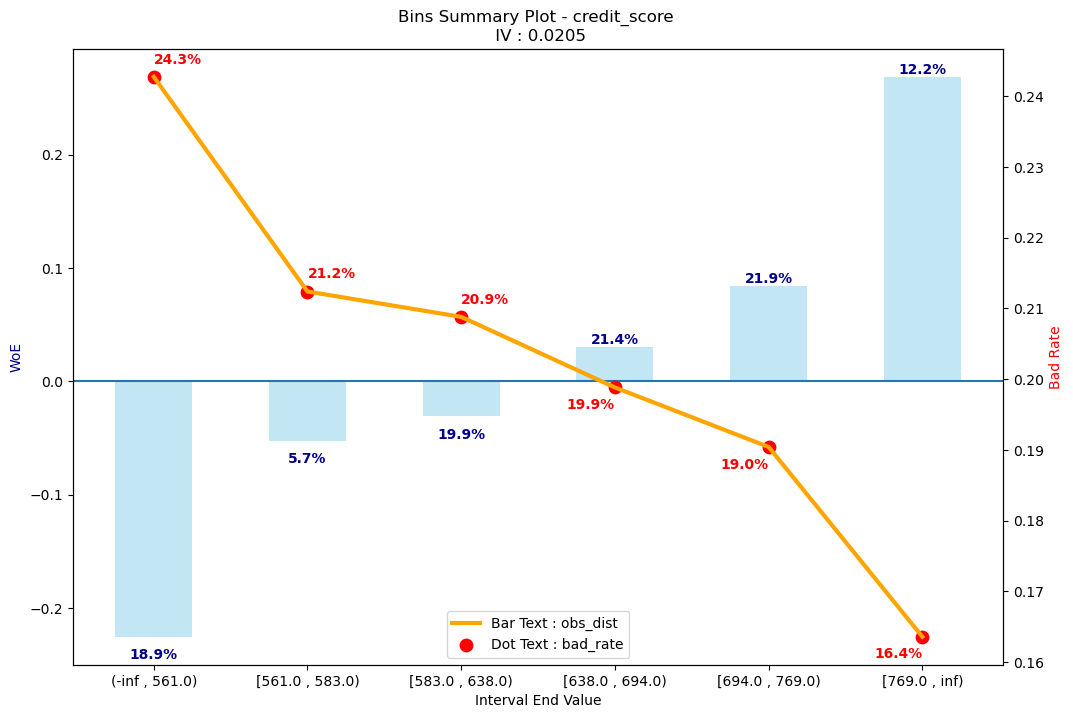

 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.38it/s]

Skipping non-numeric predictor: country
Skipping non-numeric predictor: gender
Predictor: age
IV: 0.6974461804959733


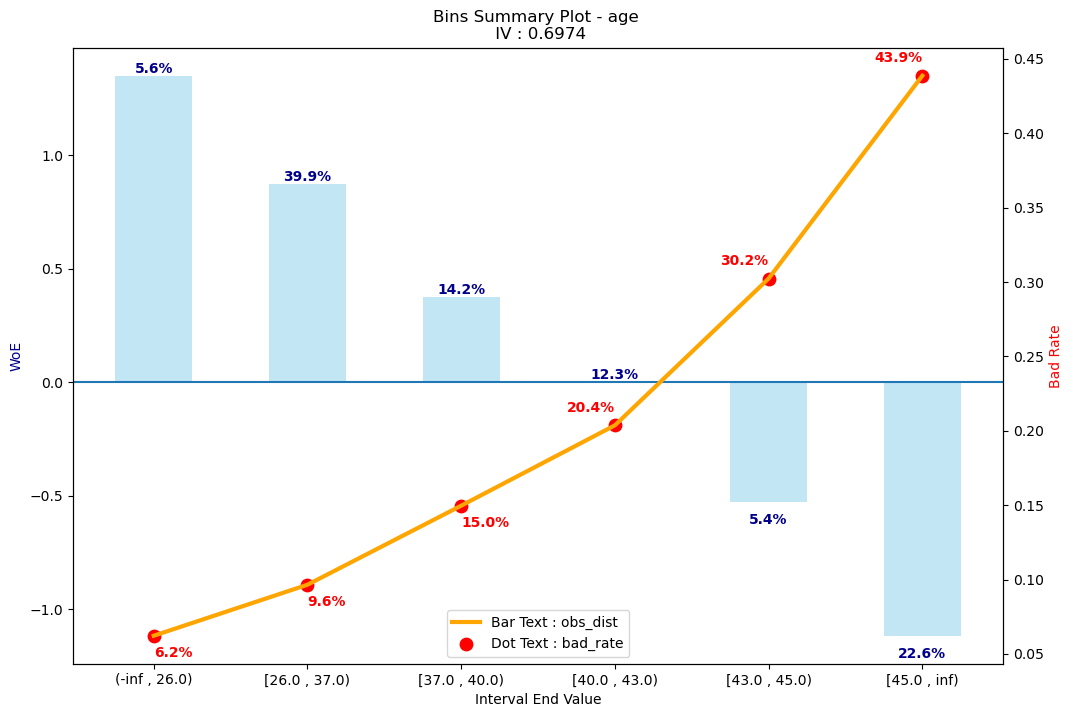

 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:01,  3.13it/s]

Predictor: tenure
IV: 0.004893369491051402


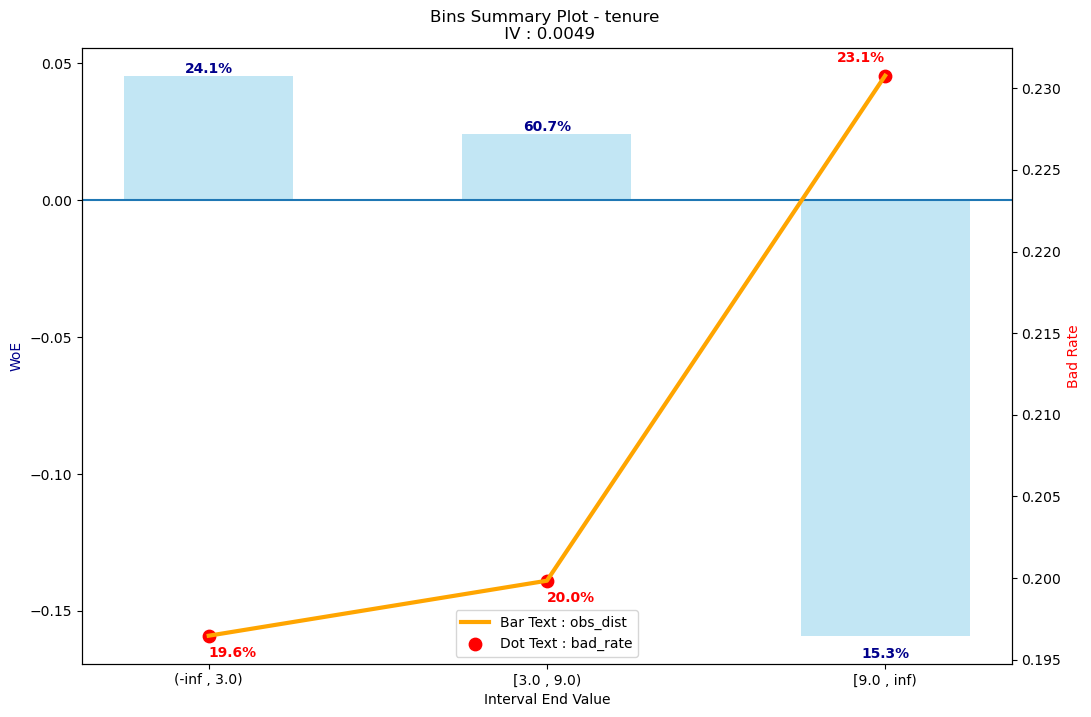

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:01,  2.50it/s]

Predictor: balance
IV: 0.11534759721074436


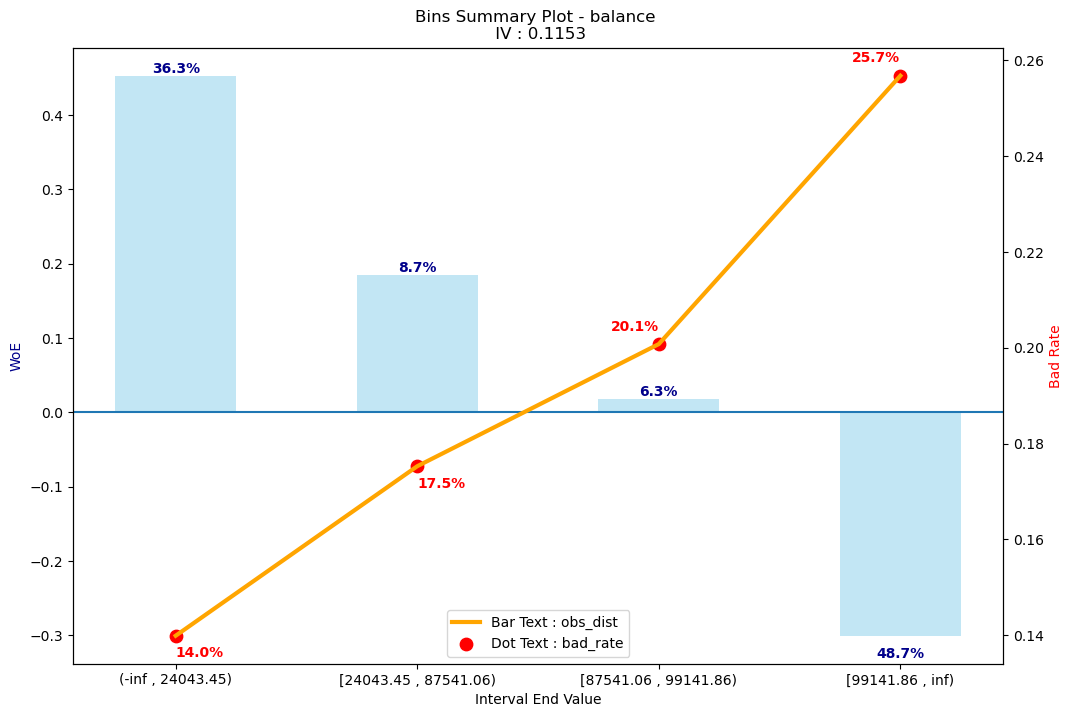

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:02<00:01,  2.17it/s]

Predictor: products_number
IV: 0.20830672652892201


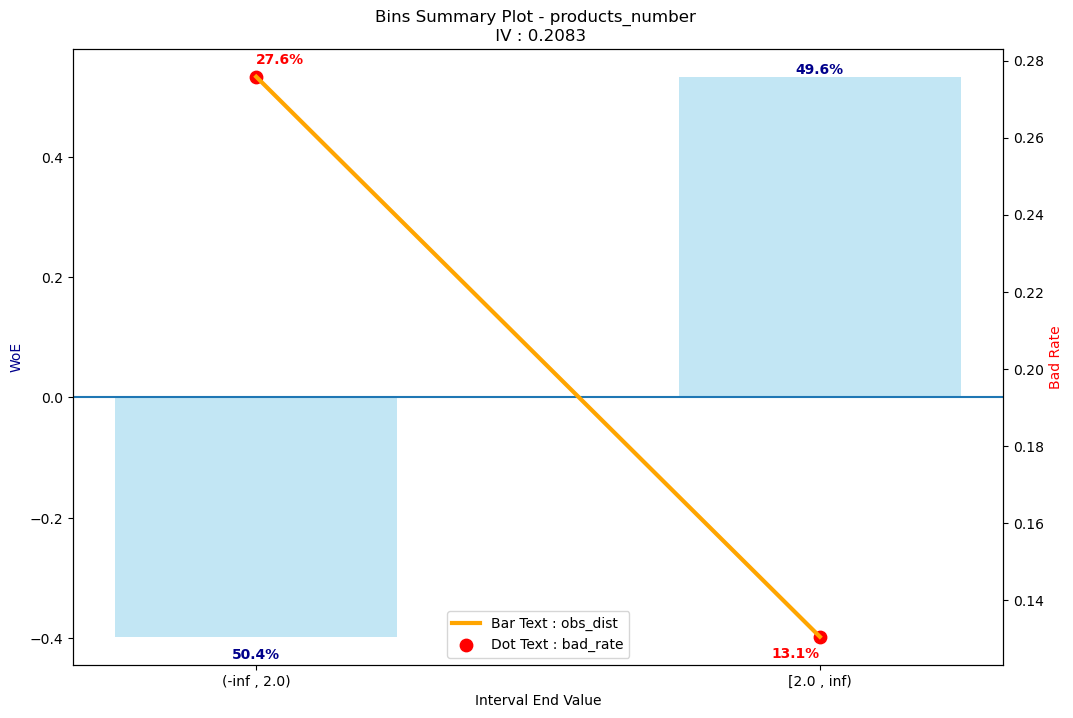

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.93it/s]

Predictor: credit_card
IV: 0.00046065794227214687


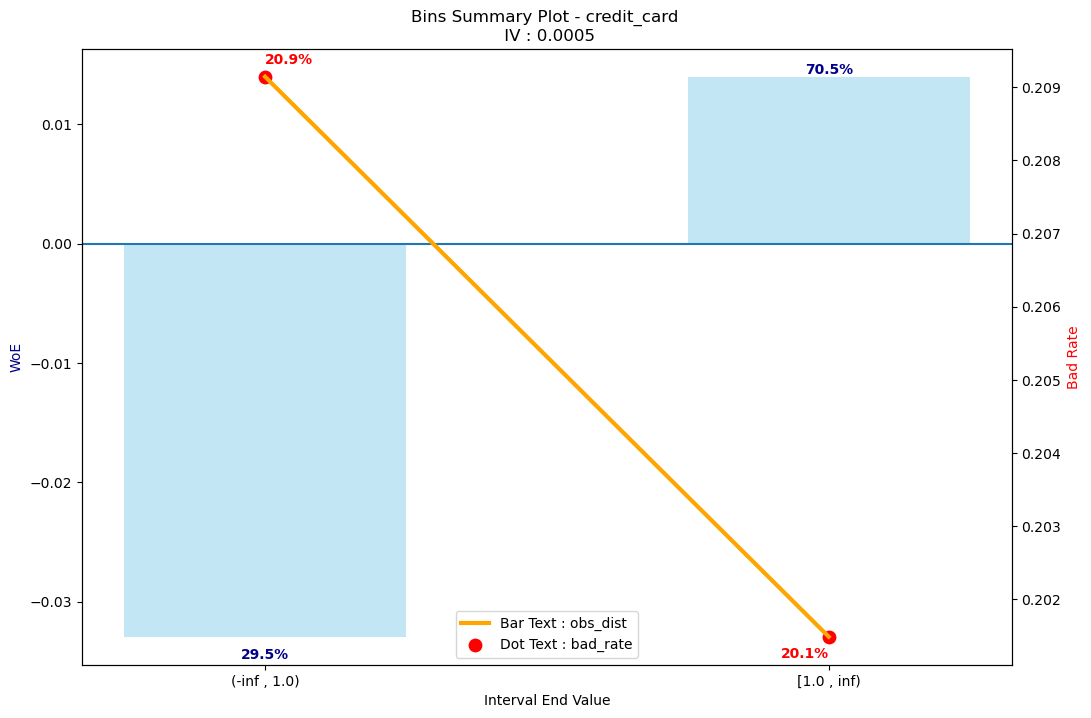

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:03<00:01,  1.86it/s]

Predictor: active_member
IV: 0.12172573204453313


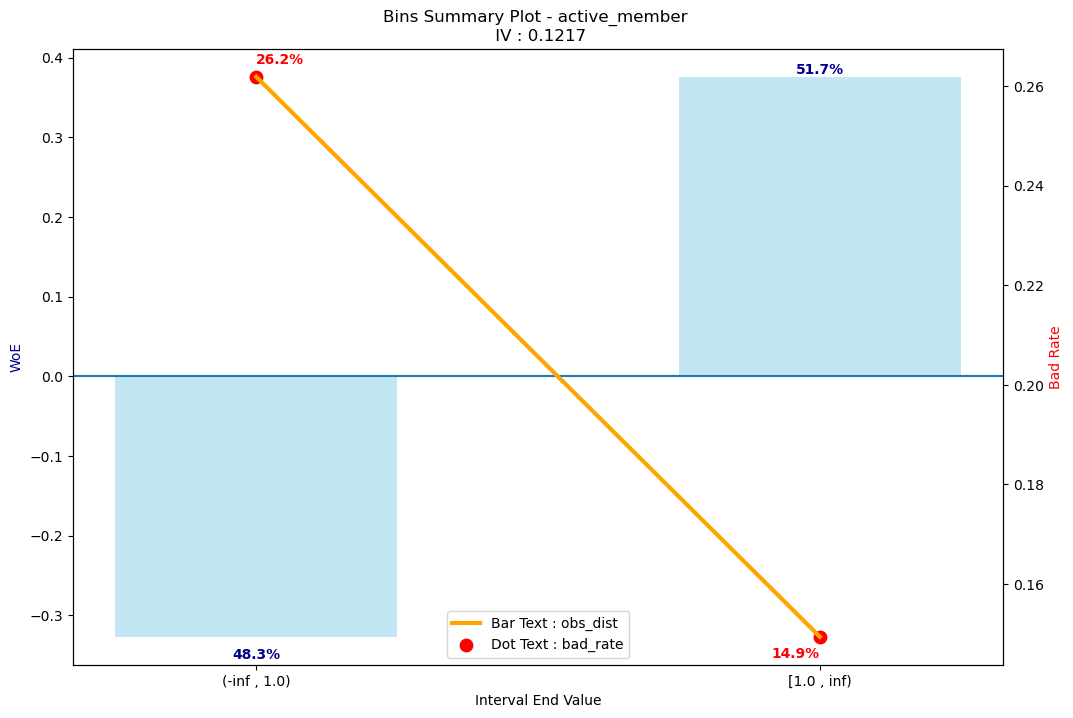

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:04<00:00,  1.76it/s]

Predictor: estimated_salary
IV: 0.010615015617380538


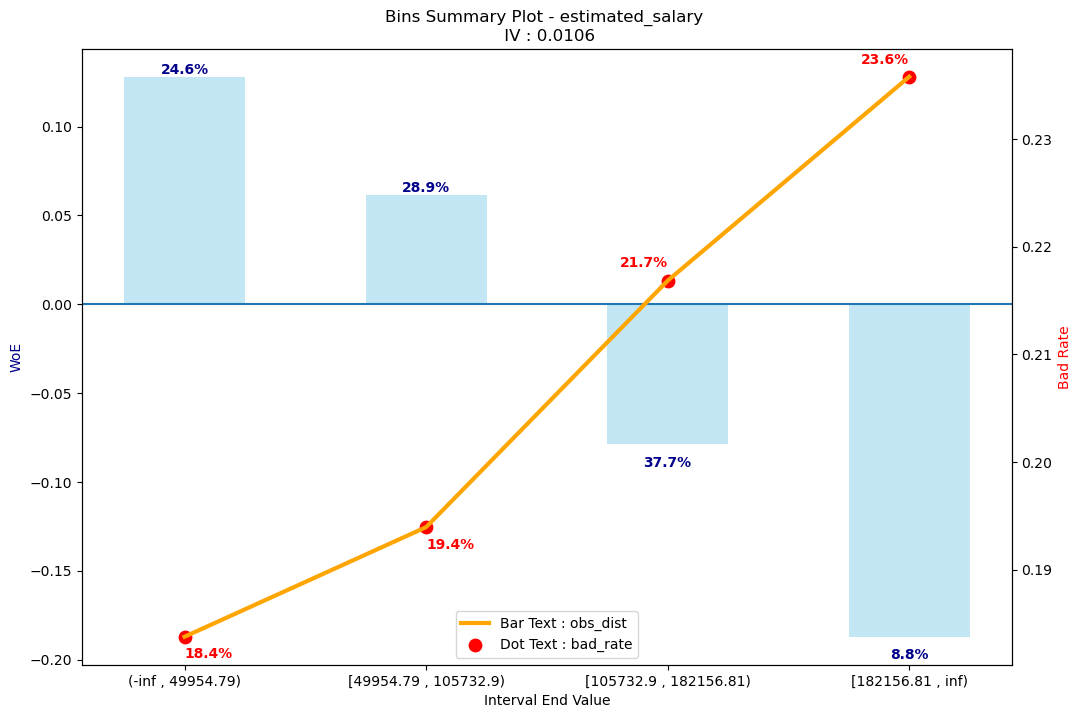

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


In [34]:
# plot the bin summary data for numerical columns
save_folder = os.path.join(output_folder, "predictors")

for pred in tqdm(col_pred):
    
    if not np.issubdtype(data[train_mask][pred].dtype, np.number):
        print(f"Skipping non-numeric predictor: {pred}")
        continue
        
    print(f'Predictor: {pred}')
    print(f'IV: {iv_scores[pred]}')
    
    # Create a new figure and axis explicitly
    filename = os.path.join(save_folder, f"{pred}_woe.png")
    MOB_PLOT.plotBinsSummary(monoOptBinTable = binning_df[pred], figsavePath = filename)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Predictor: country
IV: 0.1704


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,woe,iv_grp
0,country,France,2030,1712,318,0.156650,0.50750,0.537520,0.390184,0.320347,0.047198
2,country,Spain,963,792,171,0.177570,0.24075,0.248666,0.209816,0.169878,0.006600
1,country,Germany,1007,681,326,0.323734,0.25175,0.213815,0.400000,-0.626355,0.116618


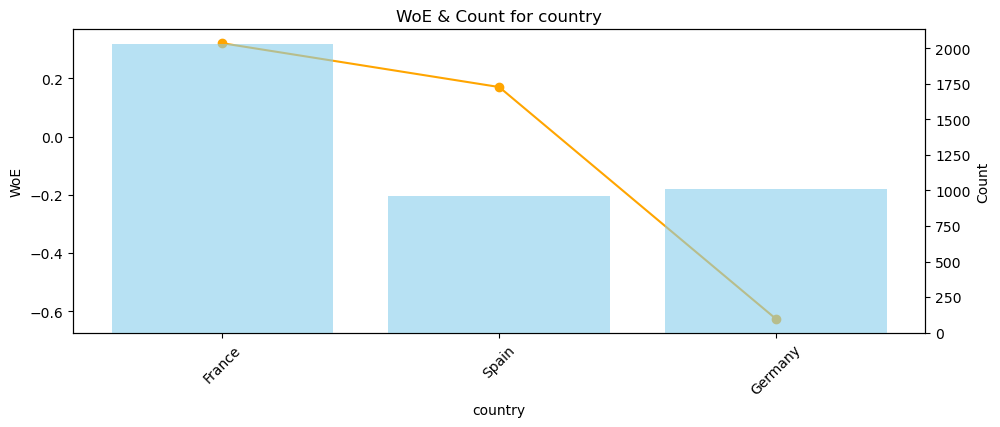

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  2.10it/s]

Predictor: gender
IV: 0.0678


,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,woe,iv_grp
0,gender,Male,2200,1836,364,0.165455,0.55,0.576452,0.446626,0.255171,0.033128
1,gender,Female,1800,1349,451,0.250556,0.45,0.423548,0.553374,-0.267368,0.034711


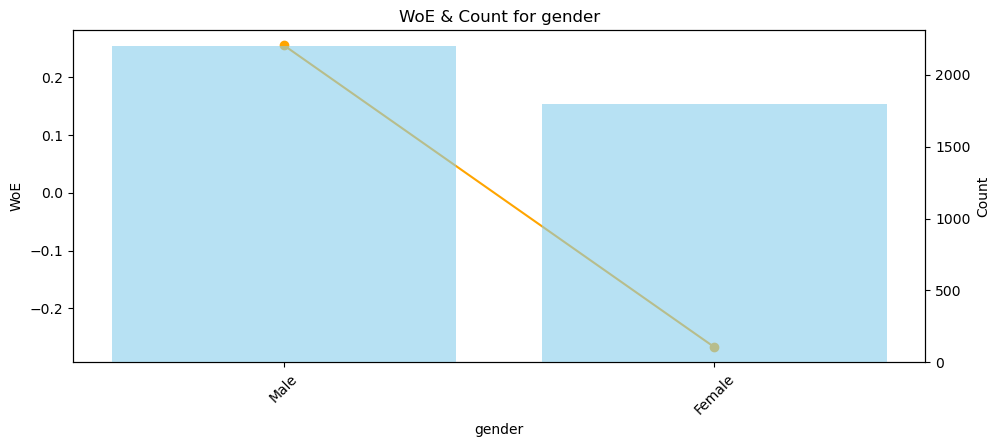

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]


In [35]:
# calculate WoE and plot bin for categorical columns
woe_df = {}
save_folder = os.path.join(output_folder, "predictors")

for pred in tqdm(col_pred_cat):
    woe_df[pred], iv = calculate_woe_iv(data[train_mask], pred, col_target)
    print(f"Predictor: {pred}")
    print(f"IV: {iv:.4f}")
    display(woe_df[pred])

    # Plot WoE & Counts
    fig, ax = plt.subplots(figsize=(12, 6))
    woe_df[pred]['Value'] = woe_df[pred]['Value'].astype(str)

    ax.plot(woe_df[pred]['Value'], woe_df[pred]['woe'], color='orange', marker='o', label='WoE')
    ax.set_xlabel(pred)
    ax.set_ylabel('WoE')
    ax.tick_params(axis='x', rotation=45)

    ax2 = ax.twinx()
    ax2.bar(woe_df[pred]['Value'], woe_df[pred]['All'], color='skyblue', alpha=0.6, label='Count')
    ax2.set_ylabel('Count')
    
    # Save binning to documentation
    filename = os.path.join(save_folder, f"{pred}_binning.csv")
    woe_df[pred].to_csv(filename)
    
    # Save the figure to documentation
    filename = os.path.join(save_folder, f"{pred}_woe.png")
    fig.savefig(filename, bbox_inches='tight', dpi=300)

    plt.title(f'WoE & Count for {pred}')
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [37]:
data

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,datatype,base
0,15604832,633,France,Male,29,7,0.00,1,1,1,130224.73,0,Train,1
1,15793693,694,France,Male,60,9,0.00,1,1,1,57088.97,0,Train,1
2,15804150,755,France,Male,34,3,0.00,2,1,1,158816.03,0,Train,1
3,15801994,775,France,Male,31,9,0.00,2,1,0,169278.51,0,Train,1
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,44384.57,1,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15772216,738,France,Female,67,1,130652.52,1,0,1,22762.23,0,Test,1
9996,15680895,627,Spain,Female,35,7,0.00,1,1,0,187718.26,0,Test,1
9997,15765650,501,Germany,Male,40,5,114655.58,1,0,0,126535.92,0,Test,1
9998,15663446,792,Germany,Female,29,4,107601.79,1,1,0,18922.18,1,Test,1


### Apply WoE to Data

In [38]:
woe_df.keys()

dict_keys(['country', 'gender'])

In [39]:
binning_df.keys()

dict_keys(['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary'])

In [40]:
binning_df['age']

,[intervalStart,intervalEnd),nsamples,bads,bad_rate,dist_obs,dist_bads,goods,dist_goods,woe,iv_grp,Value
age,,,,,,,,,,,,
0,-inf,26.0,225.0,14.0,0.062222,0.05625,0.017178,211.0,0.066248,1.349781,6.623394e-02,"(-inf, 26.0]"
1,26.0,37.0,1596.0,154.0,0.096491,0.39900,0.188957,1442.0,0.452747,0.873814,2.305036e-01,"(26.0, 37.0]"
2,37.0,40.0,568.0,85.0,0.149648,0.14200,0.104294,483.0,0.151648,0.374346,1.772673e-02,"(37.0, 40.0]"
3,40.0,43.0,491.0,100.0,0.203666,0.12275,0.122699,391.0,0.122763,0.000518,3.292145e-08,"(40.0, 43.0]"
4,43.0,45.0,215.0,65.0,0.302326,0.05375,0.079755,150.0,0.047096,-0.526771,1.720374e-02,"(43.0, 45.0]"
5,45.0,inf,905.0,397.0,0.438674,0.22625,0.487117,508.0,0.159498,-1.116474,3.657781e-01,"(45.0, inf]"


In [41]:
woe_df['country']

,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,woe,iv_grp
0,country,France,2030,1712,318,0.156650,0.50750,0.537520,0.390184,0.320347,0.047198
2,country,Spain,963,792,171,0.177570,0.24075,0.248666,0.209816,0.169878,0.006600
1,country,Germany,1007,681,326,0.323734,0.25175,0.213815,0.400000,-0.626355,0.116618


In [42]:
col_woe = []

def assign_woe_values(df, df_woe, col_pred):
    if col_pred in col_pred_cat:
        # Categorical mapping
        woe_map = dict(zip(df_woe[col_pred]['Value'].astype(str), df_woe[col_pred]['woe']))
        woe_maps[col_pred] = woe_map

        col_pred_woe = f'{col_pred}_woe'
        df[col_pred_woe] = df[col_pred].astype(str).map(woe_map)
        print(df[[col_pred, col_pred_woe]].dropna().head(3))
        col_woe.append(col_pred_woe)
        return df

    elif col_pred in col_pred_num:
        # Binning and WoE mapping for numerical column
        df_binning = df_woe[col_pred].copy()

        # Ensure numeric type
        df_binning['[intervalStart'] = pd.to_numeric(df_binning['[intervalStart'], errors='coerce')
        df_binning['intervalEnd)'] = pd.to_numeric(df_binning['intervalEnd)'], errors='coerce')
        df[col_pred] = pd.to_numeric(df[col_pred], errors='coerce')

        # Drop NaNs in bin edges just in case
        df_binning.dropna(subset=['[intervalStart', 'intervalEnd)'], inplace=True)

        # Create interval index
        intervals = pd.IntervalIndex.from_arrays(
            df_binning['[intervalStart'],
            df_binning['intervalEnd)'],
            closed='right'
        )
        
        # Create bin column using cut with exact intervals
        col_bin = f'{col_pred}_bin'
        df[col_bin] = pd.cut(df[col_pred], bins=intervals)
        
        # Map WoE to bins
        woe_map = dict(zip(intervals, df_binning['woe']))
        col_pred_woe = f'{col_pred}_woe'
        df[col_pred_woe] = df[col_bin].map(woe_map)
        df.drop(col_bin, axis=1, inplace=True)

        print(df[[col_pred, col_pred_woe]].dropna().head(3))  # preview
        col_woe.append(col_pred_woe)
        return df

    else:
        print(f"Column {col_pred} is neither categorical nor numerical.")
        return df


In [43]:
woe_maps = {}

for pred in tqdm(col_pred):
#     print(pred)
    if pred in col_pred_num:
        df_woe = binning_df
        data = assign_woe_values(data, df_woe, pred)
    elif pred in col_pred_cat:
        df_woe = woe_df
        data = assign_woe_values(data, df_woe, pred)
    else:
        print(f"Column {pred} is neither categorical nor numerical.")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.64it/s]

   credit_score credit_score_woe
0           633        -0.030876
1           694         0.030601
2           755         0.084252
  country  country_woe
0  France     0.320347
1  France     0.320347
2  France     0.320347
  gender  gender_woe
0   Male    0.255171
1   Male    0.255171
2   Male    0.255171
   age   age_woe
0   29  0.873814
1   60 -1.116474
2   34  0.873814
   tenure tenure_woe
0       7   0.024305
1       9   0.024305
2       3   0.045513
   balance balance_woe
0      0.0    0.453072
1      0.0    0.453072
2      0.0    0.453072
   products_number products_number_woe
0                1           -0.397596
1                1           -0.397596
2                2           -0.397596
   credit_card credit_card_woe
0            1       -0.032931
1            1       -0.032931
2            1       -0.032931
   active_member active_member_woe
0              1         -0.326928
1              1         -0.326928
2              1         -0.326928
   estimated_salary estimate

In [44]:
data[train_mask]

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,...,credit_score_woe,country_woe,gender_woe,age_woe,tenure_woe,balance_woe,products_number_woe,credit_card_woe,active_member_woe,estimated_salary_woe
0,15604832,633,France,Male,29,7,0.00,1,1,1,...,-0.030876,0.320347,0.255171,0.873814,0.024305,0.453072,-0.397596,-0.032931,-0.326928,-0.078863
1,15793693,694,France,Male,60,9,0.00,1,1,1,...,0.030601,0.320347,0.255171,-1.116474,0.024305,0.453072,-0.397596,-0.032931,-0.326928,0.061594
2,15804150,755,France,Male,34,3,0.00,2,1,1,...,0.084252,0.320347,0.255171,0.873814,0.045513,0.453072,-0.397596,-0.032931,-0.326928,-0.078863
3,15801994,775,France,Male,31,9,0.00,2,1,0,...,0.268669,0.320347,0.255171,0.873814,0.024305,0.453072,-0.397596,-0.032931,-0.326928,-0.078863
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,...,0.030601,-0.626355,0.255171,0.873814,0.024305,-0.300380,-0.397596,-0.032931,-0.326928,0.128083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,15652693,573,France,Female,26,4,129109.02,1,0,0,...,-0.052437,0.320347,-0.267368,1.349781,0.024305,-0.300380,-0.397596,-0.032931,-0.326928,-0.078863
3996,15629475,656,France,Male,41,2,0.00,2,1,0,...,0.030601,0.320347,0.255171,0.000518,0.045513,0.453072,-0.397596,-0.032931,-0.326928,-0.078863
3997,15670914,754,France,Male,38,2,0.00,2,1,0,...,0.084252,0.320347,0.255171,0.374346,0.045513,0.453072,-0.397596,-0.032931,-0.326928,-0.078863
3998,15709338,544,France,Female,29,1,118560.55,1,1,1,...,-0.225326,0.320347,-0.267368,0.873814,0.045513,-0.300380,-0.397596,-0.032931,-0.326928,-0.078863


In [45]:
data[train_mask].columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn', 'datatype', 'base', 'credit_score_woe',
       'country_woe', 'gender_woe', 'age_woe', 'tenure_woe', 'balance_woe',
       'products_number_woe', 'credit_card_woe', 'active_member_woe',
       'estimated_salary_woe'],
      dtype='object')

### Check Total Unique WoE Values

In [46]:
col_woe

['credit_score_woe',
 'country_woe',
 'gender_woe',
 'age_woe',
 'tenure_woe',
 'balance_woe',
 'products_number_woe',
 'credit_card_woe',
 'active_member_woe',
 'estimated_salary_woe']

In [47]:
# ensure woe columns have more than 1 unique values
cols_del = list()
for col in col_woe:
    if len(data[train_mask][col].unique()) < 1:
        cols_del.append(col)
        print(f"{cols_del} will not be further used as they only have 1 unique WoE values")
    else:
        pass
    
col_pred = [col for col in col_pred if col not in cols_del]

In [48]:
cols_del

[]

In [49]:
col_pred

['credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

## Feature Selection

### Fit Standard or cross-validated model

- Reference LGBM: https://medium.com/@mohtasim.hossain2000/mastering-lightgbm-an-in-depth-guide-to-efficient-gradient-boosting-8bfeff15ee17
- Reference CV (Cross Validation): https://medium.com/@sunils0506/types-of-cross-validations-f1ad3a871f67

Advantages over other boosting algorithms:
LightGBM exhibits several advantages over other boosting algorithms, especially in terms of efficiency and speed. Some key advantages include:

1. **Optimized for Speed**: LightGBM is designed for faster training speed compared to traditional gradient boosting frameworks like XGBoost. It achieves this through efficient histogram-based algorithms for splitting and leaf-wise tree growth, reducing memory usage and speeding up computation.

2. **Handling Large Datasets**: Its proficiency particularly shines with large-scale datasets owing to its capacity to manage an extensive number of features and instances. The GOSS technique enables the algorithm to focus on instances with larger gradients, thus reducing the computational complexity and speeding up the learning process.

3. **Memory Efficiency**: LightGBM is memory-friendly due to its feature bundling method (EFB), which reduces the number of features by grouping mutually exclusive ones. This bundling technique helps decrease the memory consumption while maintaining accuracy.

4. **Highly Parallel and Scalable**: LightGBM can leverage parallel and distributed computing efficiently, making it scalable across multiple CPU cores or clusters, further enhancing its speed and performance.

5. **Improved Accuracy**: Despite its efficiency, LightGBM often achieves comparable or even better predictive accuracy than other boosting algorithms which has established it as a preferred choice among many machine learning practitioners especially in competitions and real-world applications where speed and accuracy are critical factors.

Parameter Tuning and Optimization:
Readers’ guide on parameter tuning strategies to optimize LightGBM:
Optimizing LightGBM models involves careful parameter tuning, which significantly impacts performance. Here are essential strategies for parameter tuning:

1. **Learning Rate (Shrinkage Rate)**: Start by tuning the learning rate (‘learning_rate’), a crucial hyperparameter affecting convergence speed. Lower rates generally yield more accurate models but require more trees.

2. **Number of Trees**: Tune the number of boosted trees (‘num_iterations’ or ‘num_boost_round’) using early stopping. Monitor the validation metric (‘metric’) and halt training when it stops improving.

3. **Tree-Specific Parameters**: Adjust tree-specific parameters, such as ‘num_leaves’, which controls tree complexity. Increasing this value might enhance performance but could lead to overfitting.

4. **Max Depth and Min Data in Leaf**: Fine-tune tree depth (‘max_depth’) and the minimum number of data points in a leaf node (‘min_data_in_leaf’). Higher depth or minimum data in leaves may overfit; finding the right balance is crucial.

5. **Regularization Parameters**: Experiment with regularization parameters like ‘lambda’ (L2 regularization) and ‘min_gain_to_split’ (minimum gain to perform a split). These help prevent overfitting.

6. **Feature Importance and Sampling Parameters**: Tune feature fraction (‘feature_fraction’) and bagging fraction (‘bagging_fraction’) to control the ratio of features and data used per iteration. These can enhance robustness.

7. **Parallel and GPU Parameters**: Adjust parameters related to parallelism (‘num_threads’, ‘device’) for faster training. Utilizing GPUs (‘device’=‘gpu’) can significantly accelerate computation.

8. **Categorical Features Handling**: Optimize categorical feature handling using ‘cat_feature’ and ‘cat_l2' parameters to specify categorical columns and apply L2 regularization.

9. **Optimize Data Partitioning**: Tune parameters like ‘max_bin’ and ‘min_data_in_bin’ to adjust data partitioning, especially for continuous features.

10. **Optimize for Speed and Memory**: Use parameters like ‘enable_bundle’, ‘use_missing’, and ‘categorical_feature’ to optimize LightGBM for memory and speed.

In [50]:
# Number of valid set
n_folds = 5  

model = LGBMClassifier(
    n_estimators=2500,
    learning_rate=0.05,
    num_leaves=100,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    n_jobs=-1
)

# Stratified CV setup
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Reference: https://github.com/xbeat/Machine-Learning/blob/main/Stratified%20K-Fold%20Cross-Validation%20in%20Python.md

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1141, number of negative: 4459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

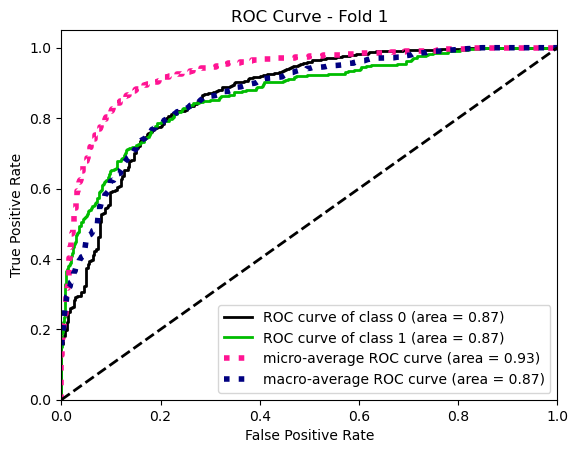

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1141, number of negative: 4459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

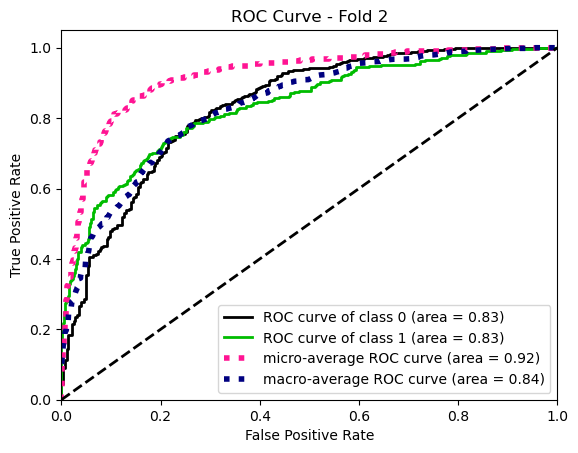

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1141, number of negative: 4459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data point

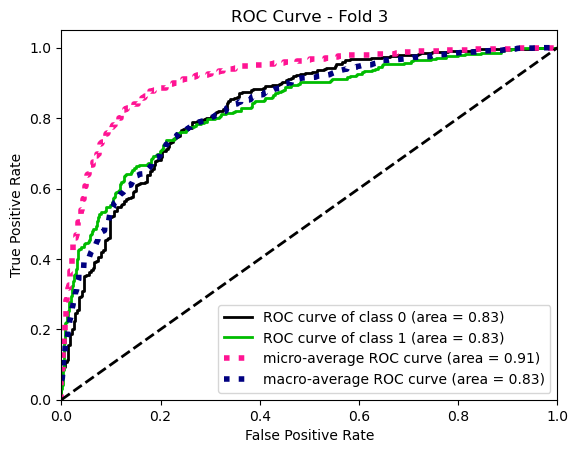

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1141, number of negative: 4459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data point

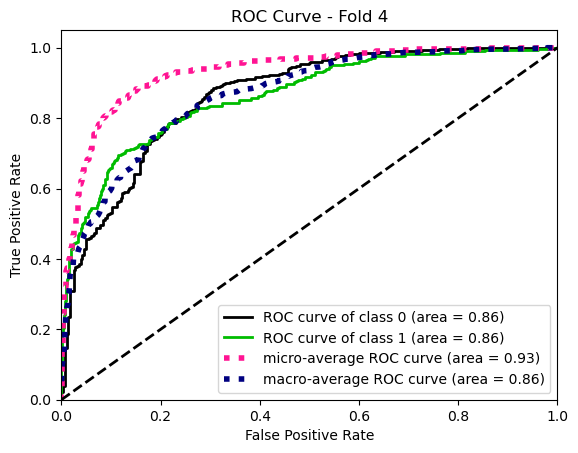

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1140, number of negative: 4460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data point

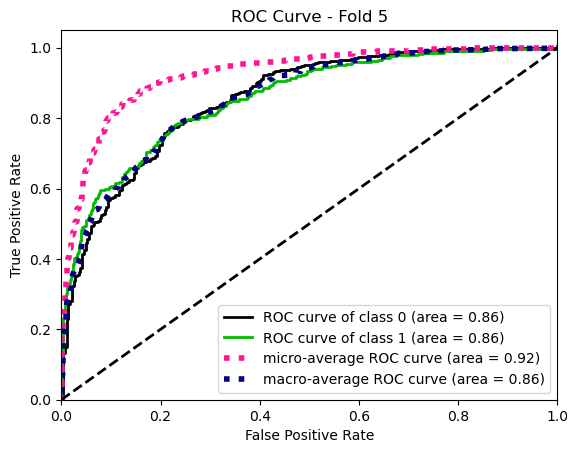


Average AUC: 0.85

Average Gini: 70.18


In [51]:
fold_aucs = []
fold_gini = []

# Data and parameters
X = data[train_mask | valid_mask][col_pred].copy()
y = data[train_mask | valid_mask][col_target].values

# Ensure categorical features are correctly typed
for col in col_pred_cat:
    X[col] = X[col].astype('category')

# Fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(100),
            log_evaluation(100)
        ],
        categorical_feature=col_pred_cat
    )

    # Prediction and AUC
    y_proba = model.predict_proba(X_val)
    
    # Handle binary classification by extracting the positive class probabilities
    if y_proba.shape[1] == 2:
        y_proba_pos = y_proba[:, 1]  # Probabilities for the positive class
    else:
        y_proba_pos = y_proba[:, 0]  # For multiclass or other cases, choose the first column
    
    # Calculate AUC and Gini
    auc = roc_auc_score(y_val, y_proba_pos)
    gini = (2 * auc - 1) * 100
    fold_aucs.append(auc)
    fold_gini.append(gini)

    print(f"Fold {fold} AUC: {auc:.2f}")
    print(f"Fold {fold} Gini: {gini:.2f}")
    
    # Plot ROC Curve
    skplt.metrics.plot_roc(y_val, y_proba)
    plt.title(f"ROC Curve - Fold {fold}")
    plt.show()

# Final results
print(f"\nAverage AUC: {np.mean(fold_aucs):.2f}")
print(f"\nAverage Gini: {np.mean(fold_gini):.2f}")


In [52]:
len(y_proba)

1400

**Prediction to unseen test dataset**

In [53]:
X_test = data[test_mask][col_pred].copy()
y_test = data[test_mask][col_target].values

# Ensure categorical features are correctly typed for test data
for col in col_pred_cat:
    X_test[col] = X_test[col].astype('category')

# Predict probabilities on the test data
y_test_proba = model.predict_proba(X_test)

# Handle binary classification
if y_test_proba.shape[1] == 2:
    y_test_proba = y_test_proba[:, 1]  # Get probabilities for the positive class
else:
    y_test_proba = y_test_proba[:, 0]  # In case of multiclass, adjust accordingly

# Calculate AUC & Gini
auc_test = roc_auc_score(y_test, y_test_proba)
gini_test = (2 * auc_test - 1) * 100

print(f"Test AUC: {auc_test:.4f}")
print(f"Test Gini: {gini_test:.2f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Test AUC: 0.8601
Test Gini: 72.02


Overfitting doesn't seem to be happening based on Gini average valid data and test data

### Gain or Weight Variable Importance

LightGBM provides two main types of feature importance scores: "Split" and "Gain."

- Split Feature Importance: This type measures the number of times a feature is used to split the data across all trees in the model. It is useful for identifying which features are most often involved in the decision-making process.
- Gain Feature Importance: Gain importance, on the other hand, quantifies the improvement in the model's accuracy achieved by using a particular feature for splitting. It provides a more informative view of feature importance, as it considers the quality of the splits as well.

Choosing the right feature importance type depends on your specific problem and goals. If you want a quick overview of which features are used most often, "Split" importance is suitable. However, if you want a more informative and accurate measure of feature importance, "Gain" importance is recommended, as it considers the quality of splits.

#### LGBM Values

In [54]:
len(col_pred)

10

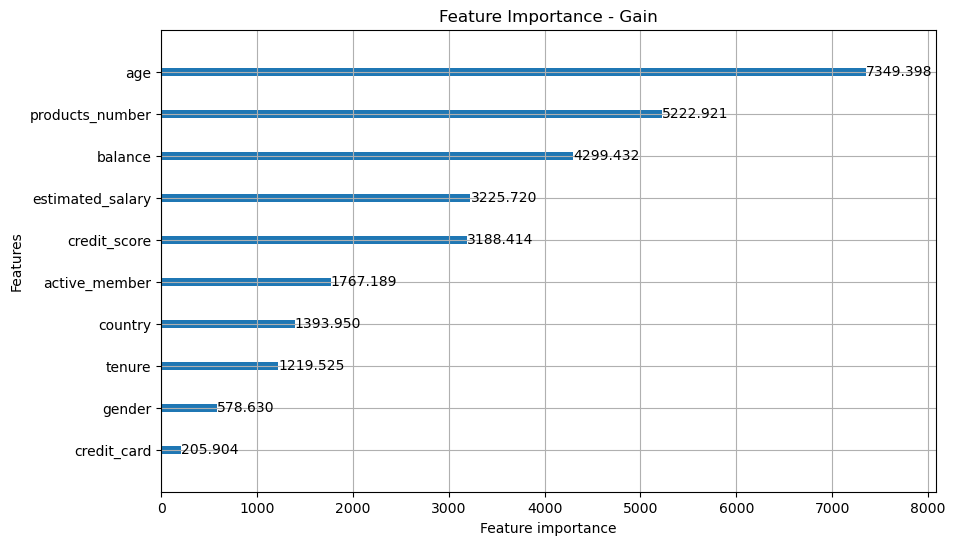

In [55]:
# Importance Gain
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance - Gain")
plt.show()

In [56]:
model

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
               learning_rate=0.05, n_estimators=2500, n_jobs=-1, num_leaves=100,
               random_state=42)

In [57]:
feature_names = model.feature_name_
importance_gain = model.booster_.feature_importance(importance_type='gain')

# Create DataFrame
var_imp_gain = pd.DataFrame({
    'feature': feature_names,
    'importance_gain': importance_gain
})
var_imp_gain = var_imp_gain.sort_values(by='importance_gain', ascending=False)
var_imp_gain

,feature,importance_gain
3,age,7349.398348
6,products_number,5222.921167
5,balance,4299.432476
9,estimated_salary,3225.720167
0,credit_score,3188.413776
8,active_member,1767.188542
1,country,1393.950263
4,tenure,1219.525449
2,gender,578.630308
7,credit_card,205.904249


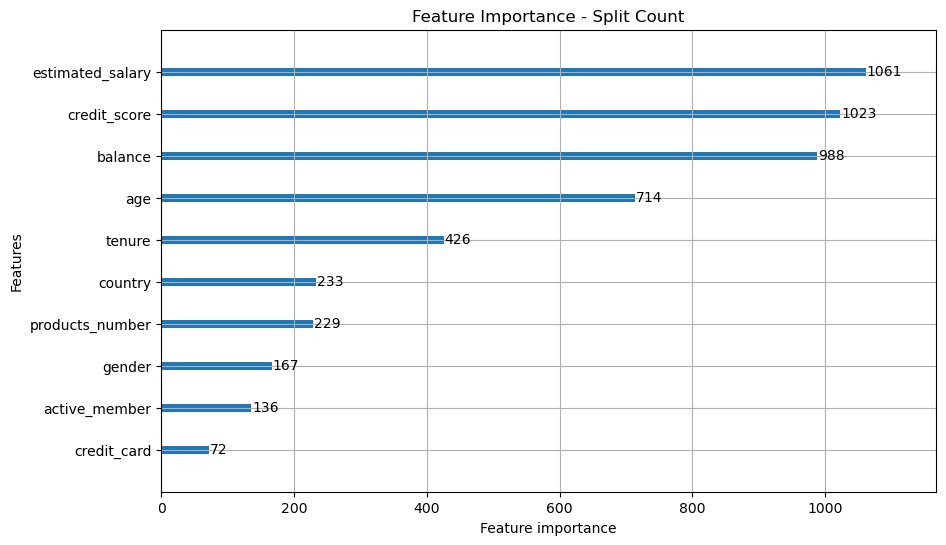

In [58]:
lgb.plot_importance(model, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title("Feature Importance - Split Count")
plt.show()

In [59]:
feature_names = model.feature_name_
importance_split = model.booster_.feature_importance(importance_type='split')

# Create DataFrame
var_imp_split = pd.DataFrame({
    'feature': feature_names,
    'importance_split': importance_split
})
var_imp_split = var_imp_split.sort_values(by='importance_split', ascending=False)
var_imp_split

,feature,importance_split
9,estimated_salary,1061
0,credit_score,1023
5,balance,988
3,age,714
4,tenure,426
1,country,233
6,products_number,229
2,gender,167
8,active_member,136
7,credit_card,72


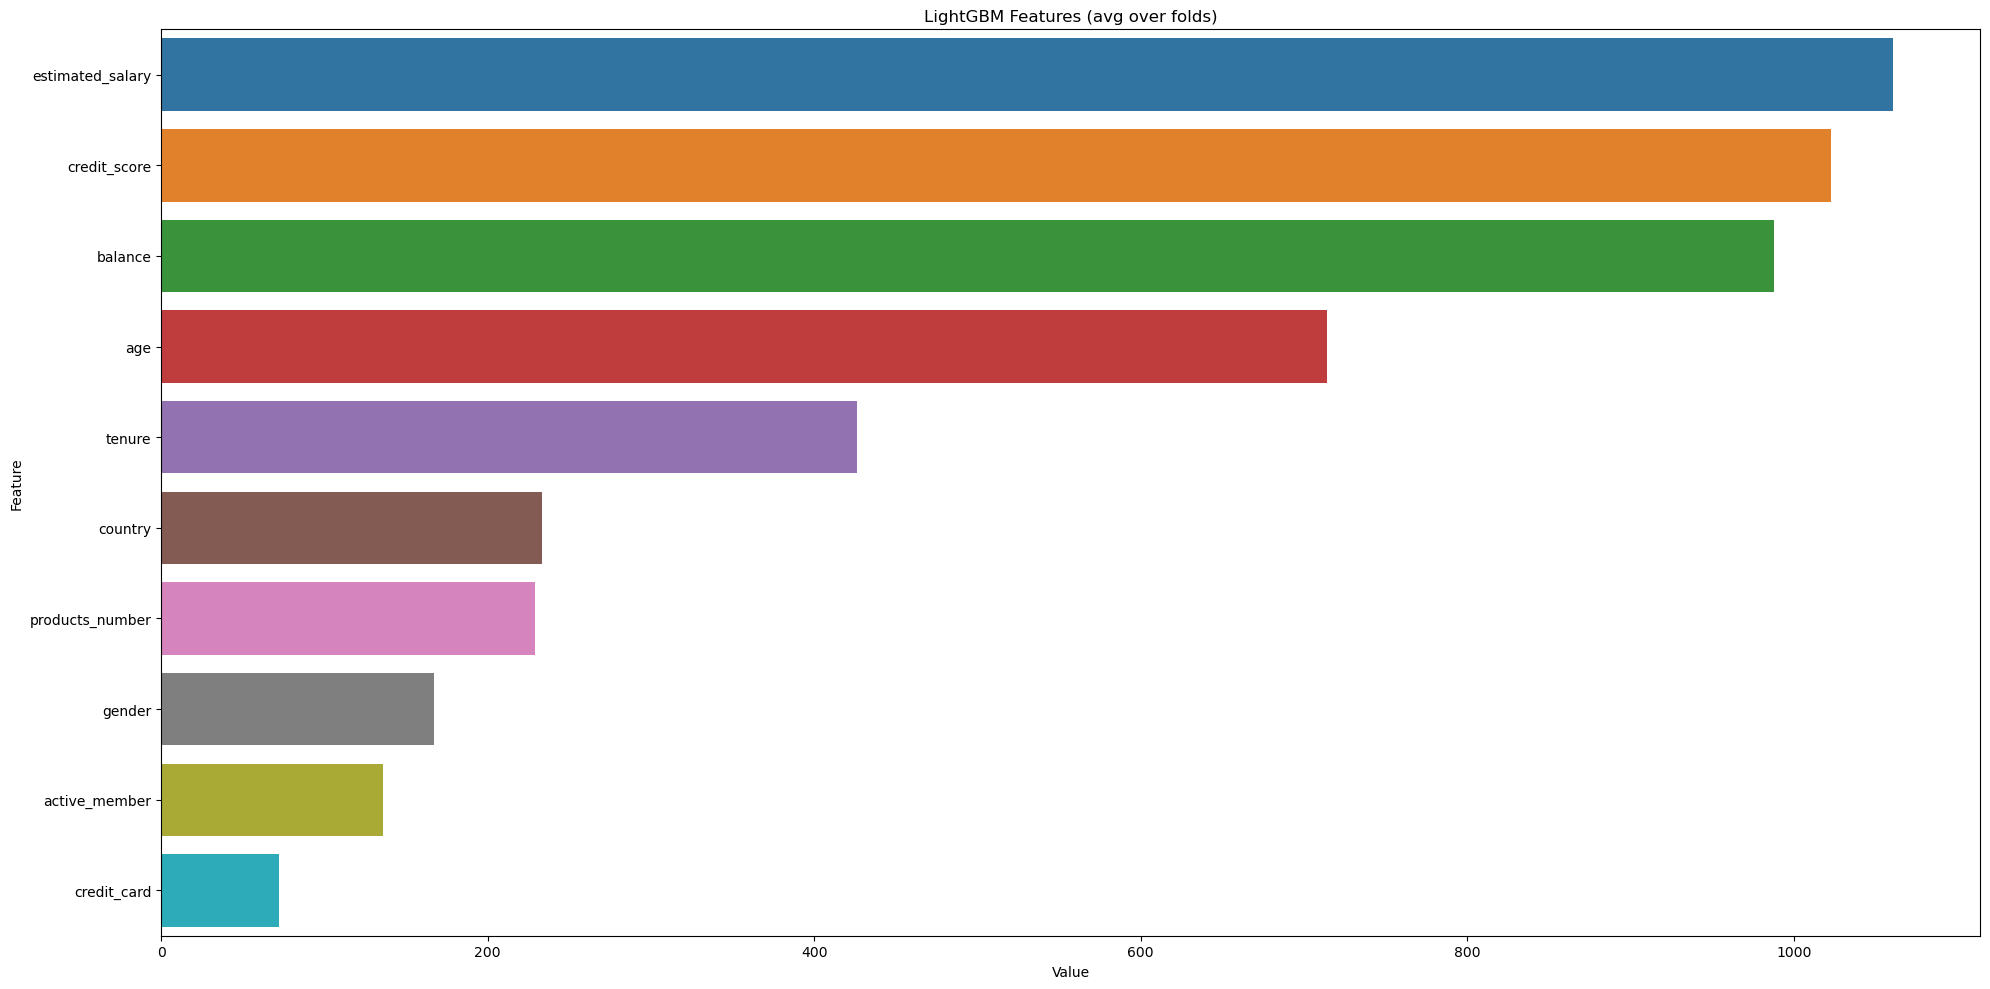

<Figure size 640x480 with 0 Axes>

In [60]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

#### SHAP Values

In [61]:
X

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,633,France,Male,29,7,0.00,1,1,1,130224.73
1,694,France,Male,60,9,0.00,1,1,1,57088.97
2,755,France,Male,34,3,0.00,2,1,1,158816.03
3,775,France,Male,31,9,0.00,2,1,0,169278.51
4,680,Germany,Male,30,4,108300.27,2,0,1,44384.57
...,...,...,...,...,...,...,...,...,...,...
6995,462,France,Male,27,4,176913.52,1,1,0,80587.27
6996,678,France,Female,31,1,0.00,2,0,1,130446.65
6997,605,France,Female,32,5,0.00,2,1,1,42135.28
6998,624,Germany,Female,52,0,133723.43,1,0,0,4859.59


In [62]:
X_test

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
7000,790,Spain,Male,37,6,0.00,2,1,1,119484.01
7001,521,France,Male,35,6,96423.84,1,1,0,10488.44
7002,712,France,Female,37,1,106881.50,2,0,0,169386.81
7003,729,Spain,Female,38,10,0.00,2,1,0,189727.12
7004,695,Germany,Male,52,8,103023.26,1,1,1,22485.64
...,...,...,...,...,...,...,...,...,...,...
9995,738,France,Female,67,1,130652.52,1,0,1,22762.23
9996,627,Spain,Female,35,7,0.00,1,1,0,187718.26
9997,501,Germany,Male,40,5,114655.58,1,0,0,126535.92
9998,792,Germany,Female,29,4,107601.79,1,1,0,18922.18


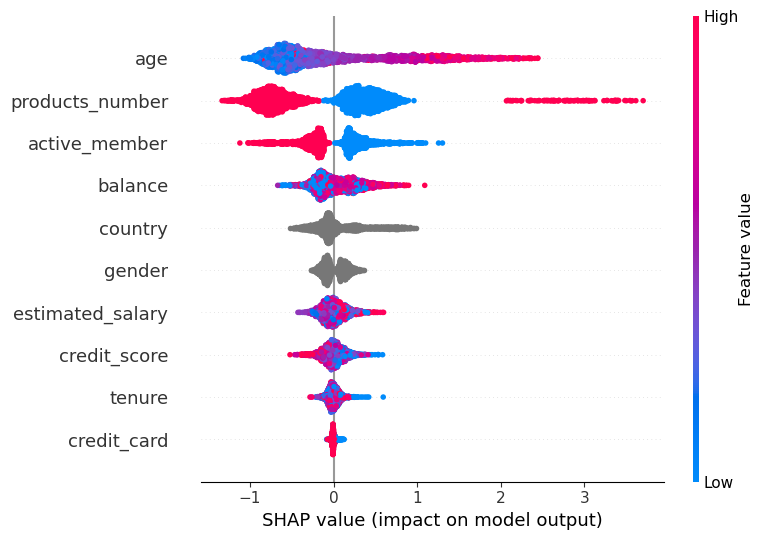

In [63]:
X_test = data[test_mask][col_pred].copy()
for col in col_pred_cat:
    categories = X[col].astype('category').cat.categories  # get train categories
    X[col] = X[col].astype(pd.CategoricalDtype(categories=categories))
    X_test[col] = X_test[col].astype(pd.CategoricalDtype(categories=categories))

# Create SHAP explainer
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

# Compute SHAP values
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


**SHAP Summary Plot** → Ranks features by importance, showing impact on predictions.
Color Interpretation:
- 🔴 Red: Increases churn probability
- 🔵 Blue: Decreases churn probability

In [64]:
var_imp_shap = pd.DataFrame({
    'feature': X_test.columns,
    'importance_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance_shap', ascending=False)

var_imp_shap

,feature,importance_shap
3,age,0.652578
6,products_number,0.615649
8,active_member,0.302240
5,balance,0.199047
1,country,0.188997
2,gender,0.118551
9,estimated_salary,0.104576
0,credit_score,0.095082
4,tenure,0.049550
7,credit_card,0.015322


### Predictor Selection

In real-world scenarios, datasets often contain a large number of predictors (e.g., 200 or more). Feature selection is important because it helps reduce noise, prevent overfitting, and improve model interpretability. Additionally, by focusing on the most relevant predictors, feature selection can significantly reduce computation time and simplify model development.

Since total predictors is low in our case, we will include them all in the first place.

In [65]:
len(col_pred)

10

In [66]:
# Get top N features from LGBM and SHAP method
woe_feature_gain = [f"{pred}" for pred in var_imp_gain.head(10)['feature'].tolist()]  # select all features due to low number of predictors
woe_feature_split = [f"{pred}" for pred in var_imp_split.head(10)['feature'].tolist()]
woe_feature_shap = [f"{pred}" for pred in var_imp_shap.head(10)['feature'].tolist()]

# Combine all features
all_features = woe_feature_gain + woe_feature_split + woe_feature_shap
cnt_feature = Counter(all_features)

# Select top N features
N = 10
col_filtered = [feature for feature, count in cnt_feature.most_common(N)]

In [67]:
col_filtered

['age',
 'products_number',
 'balance',
 'estimated_salary',
 'credit_score',
 'active_member',
 'country',
 'tenure',
 'gender',
 'credit_card']

In [68]:
cnt_feature

Counter({'age': 3,
         'products_number': 3,
         'balance': 3,
         'estimated_salary': 3,
         'credit_score': 3,
         'active_member': 3,
         'country': 3,
         'tenure': 3,
         'gender': 3,
         'credit_card': 3})

## Gini Stepwise LogReg

Reference:

- https://github.com/NaumanAnwar97/Feature-Selection/blob/main/FeatureSelection.ipynb
- https://ujangriswanto08.medium.com/how-to-perform-stepwise-regression-in-python-using-statsmodels-2d2cda4e900a

In [69]:
col_woe

['credit_score_woe',
 'country_woe',
 'gender_woe',
 'age_woe',
 'tenure_woe',
 'balance_woe',
 'products_number_woe',
 'credit_card_woe',
 'active_member_woe',
 'estimated_salary_woe']

In [70]:
def gini_score(estimator, X, y):
    try:
        y_proba = estimator.predict_proba(X)
        
        # If model only returns one column of proba (rare), assume it's the positive class
        if y_proba.shape[1] == 2:
            y_proba_pos = y_proba[:, 1]
        else:
            y_proba_pos = y_proba[:, 0]
        
        auc = roc_auc_score(y, y_proba_pos)
        return (2 * auc - 1) * 100  # Gini
    except Exception:
        return float("nan")  # Handle fold failures gracefully


In [71]:
# forward selection
model_lr = LogisticRegression(
    penalty='l2',
    C=10e10,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=10
)
sfs1 = SFS(model_lr, 
           k_features=(1, N), 
           forward=True, 
           floating=False, 
           verbose=2,
           n_jobs=-1,
           scoring=gini_score,
           cv=5)

sfs1 = sfs1.fit(data[train_mask | valid_mask][col_woe], data[train_mask | valid_mask][col_target])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished

[2025-08-14 01:04:52] Features: 1/10 -- score: 43.649745463566006[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.0s finished

[2025-08-14 01:04:53] Features: 2/10 -- score: 50.56732414717068[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2025-08-14 01:04:53] Features: 3/10 -- score: 55.24080452535827[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  

In [72]:
sfs1.k_feature_names_
sfs1.k_score_  # best AUC
# Gini = 2*AUC - 1
print("Best Gini:", sfs1.k_score_)


Best Gini: 57.747946088637505


In [73]:
len(sfs1.k_feature_names_)

7

In [74]:
col_pred_final = list(sfs1.k_feature_names_)
print(f"{len(sfs1.k_feature_names_)} final predictors are selected: {col_pred_final}")

7 final predictors are selected: ['credit_score_woe', 'country_woe', 'gender_woe', 'age_woe', 'balance_woe', 'products_number_woe', 'credit_card_woe']


In [75]:
X_final = data[train_mask | valid_mask][col_pred_final]
y_final = data[train_mask | valid_mask][col_target]

# fit logreg model
model_lr.fit(X_final, y_final)

coeff_df = pd.DataFrame({
    'feature': col_pred_final,
    'coefficient': model_lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False).reset_index(drop=True)

In [76]:
intercept_df = pd.DataFrame({
    'feature': ['intercept'],
    'coefficient': model_lr.intercept_[0]}).reset_index(drop=True)

In [77]:
full_coef_df = pd.concat([intercept_df, coeff_df], ignore_index=True)
full_coef_df

,feature,coefficient
0,intercept,1.328919
1,products_number_woe,3.509336
2,gender_woe,-0.973325
3,age_woe,-0.964940
4,country_woe,-0.788223
5,credit_score_woe,-0.709311
6,balance_woe,-0.621567
7,credit_card_woe,-0.043763


In [78]:
# save to excel
save_folder = os.path.join(output_folder, "model")
full_coef_df.to_excel(save_folder + "/coeff_predictors.xlsx", engine='openpyxl')

### Save Model

model.SW

In [79]:
model_lr

LogisticRegression(C=100000000000.0, class_weight='balanced', max_iter=1000,
                   n_jobs=10, random_state=42)

In [80]:
sfs1

SequentialFeatureSelector(estimator=LogisticRegression(C=100000000000.0,
                                                       class_weight='balanced',
                                                       max_iter=1000, n_jobs=10,
                                                       random_state=42),
                          k_features=(1, 10), n_jobs=-1,
                          scoring=<function gini_score at 0x000001FA5885C940>,
                          verbose=2)

In [81]:
save_folder = os.path.join(output_folder, "model")
model_filename = "/model_lr.model"

with open(save_folder+model_filename, "wb") as file:
    pickle.dump(model_lr, file)

## Correlation Matrix

This section is to check if final predictors selected from Gini stepwise forward selection has high correlation which can cause multicollinearity.

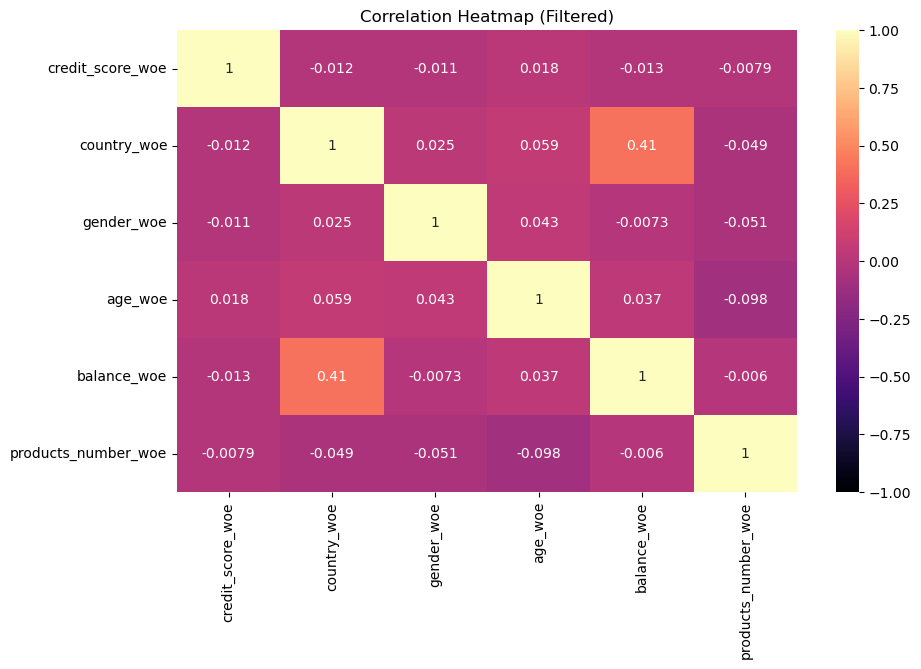

In [82]:
df_corr = data[train_mask | valid_mask][col_pred_final]
df_corr = df_corr.apply(pd.to_numeric, errors='coerce')
df_corr = df_corr.loc[:, df_corr.nunique() > 1]  # select predictors with at least 2 WoE unique values
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='magma', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Filtered)')
plt.show()

In [83]:
df_corr = data[train_mask | valid_mask][col_pred_final]
df_corr = df_corr.apply(pd.to_numeric, errors='coerce')
df_corr = df_corr.loc[:, df_corr.nunique() > 1].corr()  # select predictors with at least 2 WoE unique values

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    df_corr,
    annot=True,
    cmap='magma',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='black',
    square=True,
    fmt=".2f"
)
plt.title('Correlation Heatmap')
plt.tight_layout()

save_folder = os.path.join(output_folder, "analysis")
save_path = os.path.join(save_folder, "correlation.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

## Stability (Optional)

In [84]:
save_folder = os.path.join(output_folder, "stability")

### Predictor Stability In Time

Bad Rate, Share, Gini

### Stability Index (Optional)

### PSI Monthly and PSI per Sample (Optional)

Population Stability Index (PSI) optimally < 0.25 over the months (HOOT, DEV, OOT). PSI monitoring also as one of the good model governance after deployed.

## Cluster Surrogates (Optional)

## Model with Exact Final Predictors

Backward selection from final predictors

In [85]:
col_pred_final

['credit_score_woe',
 'country_woe',
 'gender_woe',
 'age_woe',
 'balance_woe',
 'products_number_woe',
 'credit_card_woe']

In [86]:
# backward selection from final predictor
sfs2 = SFS(
    model_lr,
    k_features=(len(col_pred_final) - 1),
    forward=False,
    scoring=gini_score,
    cv=5,
    n_jobs=-1,
    verbose=2
)
sfs2.fit(data[train_mask | valid_mask][col_pred_final], data[train_mask | valid_mask][col_target])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.6s finished

[2025-08-14 01:17:02] Features: 6/6 -- score: 57.74454745753059

SequentialFeatureSelector(estimator=LogisticRegression(C=100000000000.0,
                                                       class_weight='balanced',
                                                       max_iter=1000, n_jobs=10,
                                                       random_state=42),
                          forward=False, k_features=(6, 6), n_jobs=-1,
                          scoring=<function gini_score at 0x000001FA5885C940>,
                          verbose=2)

In [87]:
sfs2.k_feature_names_
sfs2.k_score_  # best AUC
# Gini = 2*AUC - 1
print("Best Gini:", sfs2.k_score_ )

Best Gini: 57.74454745753059


## Marginal Contribution

In [88]:
save_folder = os.path.join(output_folder, "model")

In [89]:
sfs2 = SFS(
    model_lr,
    k_features=(1, len(col_pred_final)), 
    forward=False,
    scoring=gini_score,
    cv=5,
    n_jobs=-1,
    verbose=2
)
sfs2.fit(data[train_mask | valid_mask][col_pred_final], data[train_mask | valid_mask][col_target])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.0s finished

[2025-08-14 01:17:04] Features: 6/1 -- score: 57.74454745753059[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished

[2025-08-14 01:17:04] Features: 5/1 -- score: 57.57872573262608[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2025-08-14 01:17:04] Features: 4/1 -- score: 56.82073270035859[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 |

SequentialFeatureSelector(estimator=LogisticRegression(C=100000000000.0,
                                                       class_weight='balanced',
                                                       max_iter=1000, n_jobs=10,
                                                       random_state=42),
                          forward=False, k_features=(1, 7), n_jobs=-1,
                          scoring=<function gini_score at 0x000001FA5885C940>,
                          verbose=2)

In [90]:
results = sfs2.subsets_
results

{7: {'feature_idx': (0, 1, 2, 3, 4, 5, 6),
  'cv_scores': array([58.68303045, 59.06820864, 55.88104791, 55.96129337, 59.14615008]),
  'avg_score': 57.747946088637505,
  'feature_names': ('credit_score_woe',
   'country_woe',
   'gender_woe',
   'age_woe',
   'balance_woe',
   'products_number_woe',
   'credit_card_woe')},
 6: {'feature_idx': (0, 1, 2, 3, 4, 5),
  'cv_scores': array([58.66540791, 59.06820864, 55.88104791, 55.96192274, 59.14615008]),
  'avg_score': 57.74454745753059,
  'feature_names': ('credit_score_woe',
   'country_woe',
   'gender_woe',
   'age_woe',
   'balance_woe',
   'products_number_woe')},
 5: {'feature_idx': (1, 2, 3, 4, 5),
  'cv_scores': array([59.23782551, 58.47628039, 55.15758005, 55.79136181, 59.23058091]),
  'avg_score': 57.57872573262608,
  'feature_names': ('country_woe',
   'gender_woe',
   'age_woe',
   'balance_woe',
   'products_number_woe')},
 4: {'feature_idx': (1, 2, 3, 5),
  'cv_scores': array([58.36173393, 57.24836756, 53.81512076, 56.46573834

In [91]:
print(sorted(sfs2.subsets_.keys(), reverse=True))

[7, 6, 5, 4, 3, 2, 1]


In [92]:
results = sfs2.subsets_
sorted_steps = sorted(results.keys(), reverse=True)

In [93]:
sorted_steps[1]

6

In [94]:
sorted_steps[6]

1

In [95]:
results = sfs2.subsets_
sorted_steps = sorted(results.keys(), reverse=True)  # Backward: from full model to single feature

marginal_contrib = []

for i in range(len(sorted_steps)):
    # get gini of all final predictors combined
    gini_full = results[sorted_steps[0]]['avg_score']
    
    n_feats_current = sorted_steps[i]
    current_feats = set(results[n_feats_current]['feature_idx'])
    gini_current = results[n_feats_current]['avg_score']

    # Check if next step exists
    if i + 1 < len(sorted_steps):
        n_feats_next = sorted_steps[i + 1]
        next_feats = set(results[n_feats_next]['feature_idx'])

        # Feature that was removed
        removed = current_feats - next_feats
        if removed:
            removed_feat_idx = list(removed)[0]
            removed_feat_name = col_pred_final[removed_feat_idx]
            diff = gini_current - gini_full

            marginal_contrib.append({
                'addrm': 'removed' if diff <= 0 else 'added',
                'predictor': removed_feat_name,
                'gini': gini_current,
                'diff': diff
            })
    else:
        # Final remaining feature — can't compute diff
        final_feat_idx = list(current_feats)[0]
        final_feat_name = col_pred_final[final_feat_idx]
        diff = gini_current - gini_full

        marginal_contrib.append({
            'addrm': 'removed' if diff <= 0 else 'added',
            'predictor': final_feat_name,
            'gini': gini_current,
            'diff': diff
        })

# Convert to DataFrame
marginal_df = pd.DataFrame(marginal_contrib)

In [96]:
marginal_df

,addrm,predictor,gini,diff
0,removed,credit_card_woe,57.747946,0.000000
1,removed,credit_score_woe,57.744547,-0.003399
2,removed,balance_woe,57.578726,-0.169220
3,removed,gender_woe,56.820733,-0.927213
4,removed,country_woe,55.240805,-2.507142
5,removed,products_number_woe,50.567324,-7.180622
6,removed,age_woe,43.649745,-14.098201


In [97]:
# save to excel
marginal_df.to_excel(save_folder + "/mc_pred.xlsx", engine='openpyxl')

## Scorecard Generation

In [98]:
col_pred_cat

['country', 'gender']

In [99]:
col_pred_num

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [100]:
binning_df.keys()

dict_keys(['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary'])

In [101]:
woe_df.keys()

dict_keys(['country', 'gender'])

In [102]:
binning_df['age']

,[intervalStart,intervalEnd),nsamples,bads,bad_rate,dist_obs,dist_bads,goods,dist_goods,woe,iv_grp,Value
age,,,,,,,,,,,,
0,-inf,26.0,225.0,14.0,0.062222,0.05625,0.017178,211.0,0.066248,1.349781,6.623394e-02,"(-inf, 26.0]"
1,26.0,37.0,1596.0,154.0,0.096491,0.39900,0.188957,1442.0,0.452747,0.873814,2.305036e-01,"(26.0, 37.0]"
2,37.0,40.0,568.0,85.0,0.149648,0.14200,0.104294,483.0,0.151648,0.374346,1.772673e-02,"(37.0, 40.0]"
3,40.0,43.0,491.0,100.0,0.203666,0.12275,0.122699,391.0,0.122763,0.000518,3.292145e-08,"(40.0, 43.0]"
4,43.0,45.0,215.0,65.0,0.302326,0.05375,0.079755,150.0,0.047096,-0.526771,1.720374e-02,"(43.0, 45.0]"
5,45.0,inf,905.0,397.0,0.438674,0.22625,0.487117,508.0,0.159498,-1.116474,3.657781e-01,"(45.0, inf]"


In [103]:
woe_df['gender']

,Feature,Value,All,Good,Bad,Event_rate,Prop,Prop_Good,Prop_Bad,woe,iv_grp
0,gender,Male,2200,1836,364,0.165455,0.55,0.576452,0.446626,0.255171,0.033128
1,gender,Female,1800,1349,451,0.250556,0.45,0.423548,0.553374,-0.267368,0.034711


In [104]:
full_coef_df

,feature,coefficient
0,intercept,1.328919
1,products_number_woe,3.509336
2,gender_woe,-0.973325
3,age_woe,-0.964940
4,country_woe,-0.788223
5,credit_score_woe,-0.709311
6,balance_woe,-0.621567
7,credit_card_woe,-0.043763


In [105]:
rows = []

for i, pred in enumerate(col_pred_final):
    orig_col = pred.replace('_woe', '')
    beta = full_coef_df.loc[full_coef_df['feature'] == pred, 'coefficient'].values[0]
    
    if orig_col in col_pred_cat:
        dtype = 'categorical'
        df_cat = woe_df[orig_col]

        for _, row in df_cat.iterrows():
            val = row['Value']
            woe_val = row['woe']
            bixi = woe_val * beta

            rows.append({
                'predictor': pred,
                'datatype': dtype,
                'value_desc': val,
                'woe': woe_val,
                'beta': beta,
                'bixi': bixi
            })

    else:
        dtype = 'numerical'
        df_num = binning_df[orig_col]

        for _, row in df_num.iterrows():
            bin_desc = f"[{row['[intervalStart']}, {row['intervalEnd)']})"
            woe_val = row['woe']
            bixi = woe_val * beta

            rows.append({
                'predictor': pred,
                'datatype': dtype,
                'value_desc': bin_desc,
                'woe': woe_val,
                'beta': beta,
                'bixi': bixi
            })

scorecard_df = pd.DataFrame(rows)

# append for intercept
scorecard_df = scorecard_df.append([{
    'predictor': 'Intercept',
    'datatype': 'Intercept',
    'value_desc': '',
    'woe': '',
    'beta': full_coef_df.loc[0]['coefficient'],
    'bixi': ''
}], ignore_index=True)

In [106]:
scorecard_df

,predictor,datatype,value_desc,woe,beta,bixi
0,credit_score_woe,numerical,"[-inf, 561.0)",-0.225326,-0.709311,0.159826
1,credit_score_woe,numerical,"[561.0, 583.0)",-0.052437,-0.709311,0.037194
2,credit_score_woe,numerical,"[583.0, 638.0)",-0.030876,-0.709311,0.021901
3,credit_score_woe,numerical,"[638.0, 694.0)",0.030601,-0.709311,-0.021706
4,credit_score_woe,numerical,"[694.0, 769.0)",0.084252,-0.709311,-0.059761
5,credit_score_woe,numerical,"[769.0, inf)",0.268669,-0.709311,-0.19057
6,country_woe,categorical,France,0.320347,-0.788223,-0.252505
7,country_woe,categorical,Spain,0.169878,-0.788223,-0.133902
8,country_woe,categorical,Germany,-0.626355,-0.788223,0.493707
9,gender_woe,categorical,Male,0.255171,-0.973325,-0.248364


In [107]:
scorecard_df.to_excel(os.path.join(save_folder, "scorecard_model.xlsx"), index=False)

In [108]:
def parse_interval(value_desc):
    value_desc = value_desc.replace('[', '').replace(')', '').replace('inf', '1e10')
    lower, upper = value_desc.split(', ')
    return float(lower), float(upper)

woe_case_lines = []
beta_terms = []
intercept = 0.0

for predictor in scorecard_df['predictor'].unique():
    if predictor.lower() == 'intercept':
        intercept = float(scorecard_df[scorecard_df['predictor'] == predictor]['beta'].iloc[0])
        continue

    sub_df = scorecard_df[scorecard_df['predictor'] == predictor]
    dtype = sub_df['datatype'].iloc[0]
    orig_col = predictor.replace('_woe', '')
    woe_col = f"{orig_col}_WOE"
    beta = round(scorecard_df[scorecard_df['predictor'] == predictor]['beta'].iloc[0], 10)

    # Build CASE WHEN for WOE
    case_lines = [f"    CASE"]
    if dtype == "numerical":
        for _, row in sub_df.iterrows():
            lower, upper = parse_interval(row['value_desc'])
            woe = round(row['woe'], 10)
            if lower == -1e10:
                clause = f"{orig_col} < {upper}"
            elif upper == 1e10:
                clause = f"{orig_col} >= {lower}"
            else:
                clause = f"{orig_col} >= {lower} AND {orig_col} < {upper}"
            case_lines.append(f"        WHEN {clause} THEN {woe}")
    else:
        for _, row in sub_df.iterrows():
            val = row['value_desc'].replace("'", "''")
            woe = round(row['woe'], 10)
            case_lines.append(f"        WHEN {orig_col} = '{val}' THEN {woe}")
            
    case_lines.append(f"        ELSE 0.0")
    case_lines.append(f"    END AS {woe_col},")

    woe_case_lines.extend(case_lines)
    beta_terms.append(f"{woe_col} * {beta}")

# Remove trailing comma in last predictor for SQL syntax
woe_case_lines[-1] = woe_case_lines[-1].rstrip(',')

# Initialize
sql_lines = []

# First CTE: WOE columns
sql_lines.append("WITH woe_cte AS (")
sql_lines.append("  SELECT")
sql_lines += woe_case_lines
sql_lines.append("  FROM your_input_table")
sql_lines.append("),")

# Second CTE: Linear score
sql_lines.append("linear_score_cte AS (")
sql_lines.append("  SELECT")

# Add each beta_term on a new line with indentation
for term in beta_terms:
    sql_lines.append(f"    {term} +")

sql_lines.append(f"    {intercept} AS LINEAR_SCORE,")
sql_lines.append("    wc.*")
sql_lines.append("  FROM woe_cte   wc")
sql_lines.append(")")

# Final SELECT: Probability score
sql_lines.append("SELECT")
sql_lines.append("  1 / (1 + EXP(-LINEAR_SCORE)) AS SCORE,")
sql_lines.append("  lsc.*")
sql_lines.append("FROM linear_score_cte  lsc;")

# Save SQL to file
sql_path = os.path.join(save_folder, "scorecard_model.sql")
with open(sql_path, "w", encoding="utf-8") as f:
    f.write("\n".join(sql_lines))

print(f"✅ Full scorecard SQL saved to: {sql_path}")


✅ Full scorecard SQL saved to: D:\Superprof\Materials\Documentation\documentation_module_logreg\documentation_model\model\scorecard_model.sql


In [187]:
# calculate score for all data
all_indices = train_mask | valid_mask | test_mask 

# Select the rows only once
X_all = data.loc[all_indices, col_pred_final]
y_all = data.loc[all_indices, col_target]

y_all_pred = model_lr.predict_proba(X_all)[:, 1]
data.loc[all_indices, 'churn_score'] = y_all_pred

## Modelling Performance Result

In [109]:
save_folder = os.path.join(output_folder, "performance")

### Performance per Sample

In [110]:
def gini(y_true, y_scores):
    auc = roc_auc_score(y_true, y_scores)
    return (2 * auc - 1) * 100

In [111]:
col_pred_final

['credit_score_woe',
 'country_woe',
 'gender_woe',
 'age_woe',
 'balance_woe',
 'products_number_woe',
 'credit_card_woe']

In [112]:
X_train = data[train_mask][col_pred_final]
y_train = data[train_mask][col_target]

X_valid = data[valid_mask][col_pred_final]
y_valid = data[valid_mask][col_target]

X_test = data[test_mask][col_pred_final]
y_test = data[test_mask][col_target]

In [113]:
model_lr

LogisticRegression(C=100000000000.0, class_weight='balanced', max_iter=1000,
                   n_jobs=10, random_state=42)

In [114]:
y_train_pred = model_lr.predict_proba(X_train)[:, 1]
y_valid_pred = model_lr.predict_proba(X_valid)[:, 1]
y_test_pred = model_lr.predict_proba(X_test)[:, 1]

In [115]:
gini_train = gini(y_train, y_train_pred)
gini_valid = gini(y_valid, y_valid_pred)
gini_test = gini(y_test, y_test_pred)

In [116]:
gini_train

58.07483314231781

In [117]:
gini_valid

57.6938491271026

In [118]:
gini_test

62.163667491277195

In [119]:
def lift_score(y_true, y_pred_proba, top_percent=0.1):
    data = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    data.sort_values('y_pred_proba', ascending=False, inplace=True)
    
    cutoff = int(len(data) * top_percent)
    top_data = data.iloc[:cutoff]

    positive_rate_top = top_data['y_true'].mean()
    baseline_rate = data['y_true'].mean()

    lift = positive_rate_top / baseline_rate if baseline_rate > 0 else 0
    return lift

In [120]:
lift_train = lift_score(y_train, y_train_pred, top_percent=0.1)
lift_valid = lift_score(y_valid, y_valid_pred, top_percent=0.1)
lift_test = lift_score(y_test, y_test_pred, top_percent=0.1)

In [121]:
def ks_statistic(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)

In [122]:
ks_train = ks_statistic(y_train, y_train_pred)
ks_valid = ks_statistic(y_valid, y_valid_pred)
ks_test = ks_statistic(y_test, y_test_pred)

In [123]:
perf_sample = pd.DataFrame({
    'Datatype': ['Train', 'Valid', 'Test'],
    'Gini': [gini_train, gini_valid, gini_test],
    'Lift': [lift_train, lift_valid, lift_test],
    'KS': [ks_train, ks_valid, ks_test]
})

perf_sample

,Datatype,Gini,Lift,KS
0,Train,58.074833,3.337423,0.433695
1,Valid,57.693849,3.109656,0.447720
2,Test,62.163667,3.355155,0.491655


In [124]:
# save to excel
perf_sample.to_excel(save_folder + "/perf_sample.xlsx", engine='openpyxl')

### Gini Stability In Time

Plotting to check whether Gini is stable over time in all period (HOOT, DEV, OOT)

### Performance vs Old Score (Optional)

### Callibration Chart (Optional)

## Documentation All

HTML

In [177]:
model_name = "Churn model of Bank Customer" 
author_name = "Joshua Vincentius" 
old_score_comparison_done = False

In [180]:
# ======================
# HTML Helper Functions
# ======================
def html_header(title):
    return f"""<html>
<head>
<title>{title}</title>
<meta charset="utf-8">
<style>
body {{ font: normal 10pt Helvetica, Arial, sans-serif; }}
.textbold {{ font-weight: bold; }}
.divcode {{ font-family: Courier New, Courier, Lucida Sans Typewriter, Lucida Typewriter, monospace; }}
.divpic {{ padding-bottom: 20pt; }}
.textlabel {{ font-style: italic; font-size: 8pt; }}
table {{ border-collapse: collapse; }}
</style>
</head>
<body>
"""

def html_footer():
    return "</body></html>"

def section(title, level=2):
    return f"<h{level}>{title}</h{level}>\n"

def div_text(label, value):
    return f'<div class="divtext"><span class="textbold">{label}:</span> {value}</div>\n'

def div_table(df):
    return f'<div class="divtab">\n{df.to_html(na_rep="")}\n</div>\n'

def div_image(path, label=None):
    label_html = f'<br /><span class="textlabel">{label}</span>' if label else ''
    return f'<div class="divpic"><img src="{path}" />{label_html}</div>\n'

def div_code_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        code_html = f.read().replace(" ", "&nbsp;").replace("\n", "<br />")
    return f'<div class="divcode">\n{code_html}\n</div>\n'

def div_notes(points):
    html_points = "".join([f"<li>{p}</li>\n" for p in points])
    return f"<div style='color:red;font-weight:bold;'>Notes</div>\n<ul>\n{html_points}</ul>\n"

# ======================
# Main Documentation Generator
# ======================
def generate_documentation(output_folder, model_name, author_name,
                            short_target_analysis_done=False, old_score_comparison_done=False):

    html_content = []
    html_content.append(html_header(model_name))
    html_content.append(section(f"{model_name} - documentation", 1))

    # Document Information
    html_content.append(section("Document information"))
    html_content.append('<div class="divpar">\n')
    html_content.append(div_text("Author", author_name))
    html_content.append(div_text("Generated Date", datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
    html_content.append("</div>\n")

    # Sample characteristics image
    html_content.append(section("Sample characteristics", 3))
    html_content.append('<div class="divpar">\n')
    html_content.append(div_image("analysis/data_badrate.png", "Observations and defaults in time"))

    # Final Scorecard
    html_content.append(section("Final scorecard"))
    html_content.append(section("Scorecard", 3))
    scorecard_df = pd.read_excel(os.path.join(output_folder, "model/scorecard_model.xlsx"),
                                 header=0, index_col=0, keep_default_na=False, na_values=[""])
    html_content.append('<div class="divpar">\n')
    html_content.append(div_table(scorecard_df))
    html_content.append("</div>\n")

    # Notes
    points = [
        "1: Only final predictors are shown."
    ]
    html_content.append(div_notes(points))

    # Scoring SQL
    html_content.append(section("Scoring SQL", 3))
    html_content.append('<div class="divpar">\n')
    html_content.append(div_code_from_file(os.path.join(output_folder, "model/scorecard_model.sql")))
    html_content.append("</div>\n")

    # Predictors
    html_content.append(section("Predictors"))
    predictors = pd.read_excel(os.path.join(output_folder, "model/coeff_predictors.xlsx"), header=None)[1].tolist()
    predictors = predictors[2:]
    for pred in predictors:
        pred0 = "".join(pred.split())[:-4]
        html_content.append(section(pred0, 3))
        html_content.append(section("Grouping", 4))
        html_content.append(div_image(f"predictors/{pred0}_woe.png"))

    # Correlations
    html_content.append(section("Correlations"))
    html_content.append(section("Correlation matrix between WOE variables", 3))
    html_content.append(div_image("analysis/correlation.png", "Correlation of WOE variables"))

    # Model Evaluation
    html_content.append(section("Model evaluation"))
    html_content.append(section("Performance", 3))
    perf_df = pd.read_excel(os.path.join(output_folder, "performance/perf_sample.xlsx"), header=0, index_col=0)
    html_content.append('<div class="divpar">\n')
    html_content.append(div_table(perf_df))
    html_content.append("</div>\n")

    html_content.append(section("Marginal Contribution", 3))
    marg_df = pd.read_excel(os.path.join(output_folder, "model/mc_pred.xlsx"), header=0, index_col=0)
    html_content.append(div_table(marg_df))

    # Optional sections
    if short_target_analysis_done:
        html_content.append(section("Performance on shorter target", 3))
        html_content.append(div_image("model/calibration.png", "Model calibration chart"))

    if old_score_comparison_done:
        html_content.append(section("Comparison with current model", 2))
        comp_df = pd.read_csv(os.path.join(output_folder, "performance/comparison_performance.csv"),
                              header=[0, 1], index_col=0)
        html_content.append(div_table(comp_df))
        html_content.append(div_image("performance/comparison_roc.png", "ROC curve"))
        html_content.append(div_image("performance/comparison_lift.png", "Lift curve"))

    # Close HTML
    html_content.append(html_footer())

    # Write file
    doc_path = os.path.join(output_folder, "documentation.html")
    abs_path = os.path.abspath(doc_path)

    with open(doc_path, "w", encoding="utf-8") as f:
        f.write("".join(html_content))

    try:
        get_ipython()  # Will raise if not in Jupyter
        display(HTML(f'<a href="file:///{abs_path}" target="_blank">Open documentation: {abs_path}</a>'))
    except Exception:
        # Not in Jupyter → open in browser
        webbrowser.open(f'file:///{abs_path}')

    print(f"Documentation generated: {abs_path}")


In [181]:
generate_documentation(
    output_folder=output_folder,
    model_name=model_name,
    author_name=author_name,
    short_target_analysis_done=False,  
    old_score_comparison_done=False   
)


Documentation generated: D:\Superprof\Materials\Documentation\documentation_module_logreg\documentation_model\documentation.html


In [188]:
data

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,...,country_woe,gender_woe,age_woe,tenure_woe,balance_woe,products_number_woe,credit_card_woe,active_member_woe,estimated_salary_woe,churn_score
0,15604832,633,France,Male,29,7,0.00,1,1,1,...,0.320347,0.255171,0.873814,0.024305,0.453072,-0.397596,-0.032931,-0.326928,-0.078863,0.158598
1,15793693,694,France,Male,60,9,0.00,1,1,1,...,0.320347,0.255171,-1.116474,0.024305,0.453072,-0.397596,-0.032931,-0.326928,0.061594,0.551864
2,15804150,755,France,Male,34,3,0.00,2,1,1,...,0.320347,0.255171,0.873814,0.045513,0.453072,-0.397596,-0.032931,-0.326928,-0.078863,0.148002
3,15801994,775,France,Male,31,9,0.00,2,1,0,...,0.320347,0.255171,0.873814,0.024305,0.453072,-0.397596,-0.032931,-0.326928,-0.078863,0.132255
4,15702601,680,Germany,Male,30,4,108300.27,2,0,1,...,-0.626355,0.255171,0.873814,0.024305,-0.300380,-0.397596,-0.032931,-0.326928,0.128083,0.378064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15772216,738,France,Female,67,1,130652.52,1,0,1,...,0.320347,-0.267368,-1.116474,0.045513,-0.300380,-0.397596,-0.032931,-0.326928,0.128083,0.758975
9996,15680895,627,Spain,Female,35,7,0.00,1,1,0,...,0.169878,-0.267368,0.873814,0.024305,0.453072,-0.397596,-0.032931,-0.326928,-0.187149,0.260861
9997,15765650,501,Germany,Male,40,5,114655.58,1,0,0,...,-0.626355,0.255171,0.374346,0.024305,-0.300380,-0.397596,-0.032931,-0.326928,-0.078863,0.541335
9998,15663446,792,Germany,Female,29,4,107601.79,1,1,0,...,-0.626355,-0.267368,0.873814,0.024305,-0.300380,-0.397596,-0.032931,-0.326928,0.128083,0.460573


In [189]:
data.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn', 'datatype', 'base', 'credit_score_woe',
       'country_woe', 'gender_woe', 'age_woe', 'tenure_woe', 'balance_woe',
       'products_number_woe', 'credit_card_woe', 'active_member_woe',
       'estimated_salary_woe', 'churn_score'],
      dtype='object')

In [190]:
output_folder

'D:\\Superprof\\Materials\\Documentation\\documentation_module_logreg\\documentation_model'

In [192]:
data.to_pickle(output_folder+'\data.pkl')

In [193]:
import shutil
import os

# Path to the folder you want to zip
folder_path = output_folder
output_zip = output_folder

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_zip), exist_ok=True)

# Check if the folder exists before trying to zip it
if os.path.exists(folder_path):
    shutil.make_archive(output_zip, 'zip', folder_path)
    print(f'Successfully created zip file: {output_zip}.zip')
else:
    print(f'Error: The folder {folder_path} does not exist.')

Successfully created zip file: D:\Superprof\Materials\Documentation\documentation_module_logreg\documentation_model.zip
